# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import xml.etree.ElementTree as ET
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nlpaug.augmenter.word as naw
from tqdm import tqdm
import tensorflow as tf
#from google.colab import drive
import numpy as np
import pandas as pd #cargar los dataset
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub # para obtener el modelo pre-entrenado de BERT
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import re
#from bs4 import BeautifulSoup
from tensorflow.keras import layers
import bert
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import random #mezclar datos
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\bryan\anaconda3\envs\GPU_IEMOCAP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3 Datasets : ISEAR, MELD y IEMOCAP

## Datasets

### ISEAR

In [3]:
isear = pd.read_excel('ISEAR.xlsx')


print(isear.head())

      ID  CITY  COUN  SUBJ  SEX  AGE  RELI  PRAC  FOCC  MOCC  ...  SELF  RELA  \
0  11001     1     1     1    1   33     1     2     6     1  ...     3     3   
1  11001     1     1     1    1   33     1     2     6     1  ...     2     2   
2  11001     1     1     1    1   33     1     2     6     1  ...     2     1   
3  11001     1     1     1    1   33     1     2     6     1  ...     1     1   
4  11001     1     1     1    1   33     1     2     6     1  ...     0     2   

   VERBAL  NEUTRO   Field1  Field3  Field2   MYKEY  \
0       2       0      joy       4       3  110011   
1       0       0     fear       3       2  110012   
2       0       0    anger       1       3  110013   
3       0       2  sadness       4       4  110014   
4       0       0  disgust       4       4  110015   

                                                 SIT  STATE  
0  During the period of falling in love, each tim...      1  
1         When I was involved in a traffic accident.      1  
2 

In [4]:
isearDataset = isear.iloc[:, [40,36]]
isearDataset = isearDataset.rename(columns={'Field1': 'label', 'SIT': 'texto'})
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
7661,Two years back someone invited me to be the tu...,anger
7662,I had taken the responsibility to do something...,sadness
7663,I was at home and I heard a loud sound of spit...,disgust
7664,I did not do the homework that the teacher had...,shame


In [5]:
def eliminarAcentos(texto):
    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    return texto
isearDataset['texto'] = isearDataset['texto'].apply(eliminarAcentos)

In [6]:
isearDataset = isearDataset.replace(to_replace=['joy', 'anger', 'sadness'], value=['happy', 'angry', 'sad']) #Reemplazar nombres de datos
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'shame'].index) #Eliminar nombres de datos de emociones que no se ocupan
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guilt'].index)
isearDataset = isearDataset.drop(isearDataset[isearDataset['label']== 'guit'].index)
isearDataset = isearDataset.reset_index(drop=True)
isearDataset

,texto,label
0,"During the period of falling in love, each tim...",happy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,angry
3,When I lost the person who meant the most to me.,sad
4,The time I knocked a deer down - the sight of ...,disgust
...,...,...
5472,I received a letter from a distant friend.,happy
5473,My parents were out and I was the eldest at ho...,fear
5474,Two years back someone invited me to be the tu...,angry
5475,I had taken the responsibility to do something...,sad


### MELD

In [7]:
dfMeld=pd.read_csv('meld_train.csv')

label = dfMeld['Emotion']
text = dfMeld['Utterance']

data = {
    'texto' : text.tolist(),
    'label' : label.tolist()
}

dfMeld= pd.DataFrame(data)

In [8]:
dfMeld = dfMeld.replace(to_replace=['joy', 'sadness', 'anger'], value=['happy', 'sad', 'angry'])
dfMeld

,texto,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


In [9]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
dfMeld['texto'] = dfMeld['texto'].apply(eliminarAcentos)
dfMeld

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


### IEMOCAP

In [10]:
iemocapDataset = pd.read_csv('df_filters.csv')
iemocapDataset

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [11]:
iemocapDataset['Emoción'].unique()

array(['neutral', 'angry', 'sad', 'happy', 'surprise', 'fear', 'disgust'],
      dtype=object)

In [11]:
iemocapDataset = iemocapDataset.rename(columns={'Emoción': 'label', 'Texto':'texto'})
iemocapDataset

,texto,label
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


### Concatenate

In [12]:
dftodo = pd.concat([dfMeld, isearDataset,iemocapDataset])
dftodo = dftodo.reset_index(drop=True)
dftodo

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
20098,oh! Marry you again? I wouldn't marry you agai...,angry
20099,Beast,angry
20100,You're a wicked little vampire. And I pray to ...,angry
20101,Brute,angry


In [14]:
dftodo['label'].value_counts()

label
neutral     6417
happy       3432
angry       3308
sad         2862
fear        1403
disgust     1369
surprise    1312
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='Count'>

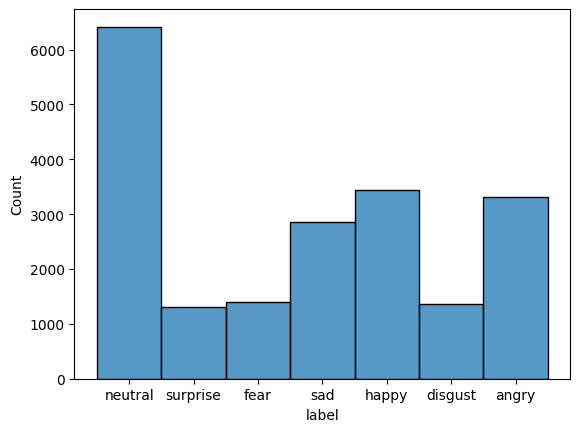

In [19]:
sns.histplot(x=dftodo['label'])

In [138]:
dftodo[20:35]

,texto,label
20,"Yeah, sure!",neutral
21,"Hey, Mon.",neutral
22,Hey-hey-hey. You wanna hear something that sucks.,neutral
23,Do I ever.,happy
24,Chris says they're closing down the bar.,sad
25,No way!,surprise
26,"Yeah, apparently they're turning it into some ...",neutral
27,Just coffee! Where are we gonna hang out now?,disgust
28,Got me.,sad
29,Can I get a beer.,neutral


## Data Balacing

### RandomOverSampler

In [45]:
random = RandomOverSampler(random_state=42)

X_resampled, y_resampled = random.fit_resample(dftodo[['texto']], dftodo['label'])

# Crear un nuevo dataframe con los datos sobremuestreados
df_resampled = pd.DataFrame(X_resampled, columns=['texto'])
df_resampled['label'] = y_resampled
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
44914,"Oh my God, I remember now! We were playing chess!",surprise
44915,What?! What else did he say?,surprise
44916,What? Why?,surprise
44917,How do you lose a suitcase? A huge suitcase?,surprise


In [46]:
df_resampled['label'].value_counts()

label
neutral     6417
surprise    6417
fear        6417
sad         6417
happy       6417
disgust     6417
angry       6417
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='Count'>

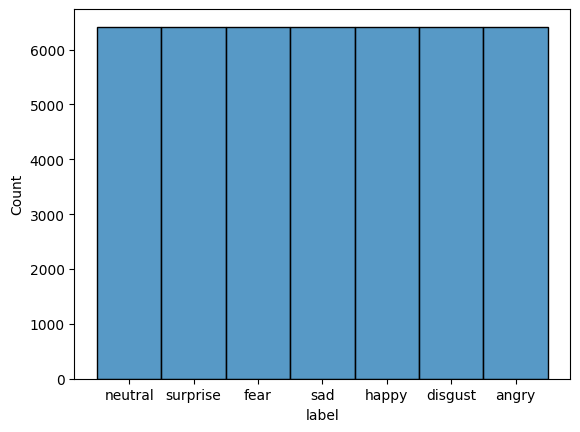

In [43]:
sns.histplot(x=df_resampled['label'])

### Similitud

In [13]:
random.seed(42)
np.random.seed(42)

aug = naw.SynonymAug(aug_src='wordnet')

conteo_clases = dftodo['label'].value_counts()

clase_mayoritaria = conteo_clases.idxmax()
conteo_mayoritario = conteo_clases.max()

df_balanceado = pd.DataFrame(columns=['texto', 'label', 'original'])


for clase in tqdm(dftodo['label'].unique()):
    df_clase = dftodo[dftodo['label'] == clase]
    
    if clase == clase_mayoritaria:
        df_clase['original'] = df_clase['texto']  
        df_balanceado = pd.concat([df_balanceado, df_clase])
    else:
        datos_faltantes = conteo_mayoritario - len(df_clase)
        

        datos_sinteticos = df_clase.sample(datos_faltantes, replace=True)
        datos_sinteticos['original'] = datos_sinteticos['texto']  
        datos_sinteticos['texto'] = datos_sinteticos['texto'].apply(aug.augment) 
        
        df_balanceado = pd.concat([df_balanceado, df_clase, datos_sinteticos])

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\bryan\AppData\Local\Temp\ipykernel_25140\1283552876.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clase['original'] = df_clase['texto']
100%|██████████| 7/7 [00:43<00:00,  6.15s/it]


In [16]:
df_balanceado['label'].value_counts()

label
neutral     6417
surprise    6417
fear        6417
sad         6417
happy       6417
disgust     6417
angry       6417
Name: count, dtype: int64

In [14]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado

,texto,label,original
0,also I was the point person on my company's tr...,neutral,also I was the point person on my company's tr...
1,You must've had your hands full.,neutral,You must've had your hands full.
2,That I did. That I did.,neutral,That I did. That I did.
3,So let's talk a little bit about your duties.,neutral,So let's talk a little bit about your duties.
4,"Now you'll be heading a whole division, so you...",neutral,"Now you'll be heading a whole division, so you..."
...,...,...,...
44914,[When I heard that my girl was spill the beans...,angry,When I heard that my girlfriend was talking be...
44915,[Thank you very much.],angry,Thank you very much.
44916,[You ' re non going nowhere. No you ' re not.],angry,You're not going nowhere. No you're not.
44917,[In the lowest year of the high school we had ...,angry,In the last year of the high school we had a h...


In [18]:
df_balanceado[80:100]

,texto,label,original
80,"Oh, yeah, Bob said there might be flood damage.",neutral,"Oh, yeah, Bob said there might be flood damage."
81,"Yeah, either that, or he has a really big cat.",neutral,"Yeah, either that, or he has a really big cat."
82,"If you said, ""Big lima bean, bubbling up."" Wou...",neutral,"If you said, ""Big lima bean, bubbling up."" Wou..."
83,Rach? What are you doing?,neutral,Rach? What are you doing?
84,It's a diaper commercial.,neutral,It's a diaper commercial.
85,"Hey, you wanna get something to eat or uh, do ...",neutral,"Hey, you wanna get something to eat or uh, do ..."
86,"Uhh, the ball thing.",neutral,"Uhh, the ball thing."
87,Yeah?,neutral,Yeah?
88,"Uhh,",neutral,"Uhh,"
89,What?,neutral,What?


In [15]:
df_resampled = pd.DataFrame({'texto': df_balanceado['texto'], 'label': df_balanceado['label']})
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,"Now you'll be heading a whole division, so you...",neutral
...,...,...
44914,[When I heard that my girl was spill the beans...,angry
44915,[Thank you very much.],angry
44916,[You ' re non going nowhere. No you ' re not.],angry
44917,[In the lowest year of the high school we had ...,angry


In [145]:
dftodo[20:35]

,texto,label
20,"Yeah, sure!",neutral
21,"Hey, Mon.",neutral
22,Hey-hey-hey. You wanna hear something that sucks.,neutral
23,Do I ever.,happy
24,Chris says they're closing down the bar.,sad
25,No way!,surprise
26,"Yeah, apparently they're turning it into some ...",neutral
27,Just coffee! Where are we gonna hang out now?,disgust
28,Got me.,sad
29,Can I get a beer.,neutral


In [146]:
df_resampled[20:35]

,texto,label
20,He was with her when he wrote this poem.,neutral
21,"Look, 'My vessel so empty with nothing inside.",neutral
22,"Now that I've touched you, you seem emptier st...",neutral
23,Done.,neutral
24,"Ah y'know, this building is on my paper route ...",neutral
25,Oh.,neutral
26,Hi.,neutral
27,Hi.,neutral
28,How'd did it go?,neutral
29,I know.,neutral


In [19]:
df_resampled['texto']

0        also I was the point person on my company's tr...
1                         You must've had your hands full.
2                                  That I did. That I did.
3            So let's talk a little bit about your duties.
4        Now you'll be heading a whole division, so you...
                               ...                        
44914    [When I heard that my girl was spill the beans...
44915                               [Thank you very much.]
44916       [You ' re non going nowhere. No you ' re not.]
44917    [In the lowest year of the high school we had ...
44918    [A man kept a seat taken by put his coat on it...
Name: texto, Length: 44919, dtype: object

## Data Cleansing and transformation

In [16]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:

lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ #Se etiqueta como un adjetivo
    elif nltk_tag.startswith('V'):
        return wordnet.VERB #Se etiqueta como un verbo
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN #Se etiqueta como un sustantivo
    elif nltk_tag.startswith('R'):
        return wordnet.ADV #Se etiqueta como un adverbio
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean = [clean_emotion_text(text) for text in tqdm(df_resampled['texto'])]

100%|██████████| 44919/44919 [01:15<00:00, 598.47it/s]


In [21]:
texto_clean[-10:-1]

['betsy griscom ross add up on!',
 'hey!',
 "when my roommate'randomness moon around be steal i be rattle angry.",
 "limited seat my bum. rent's see world health organization make the cut. hawaii!",
 "jealous of my married man's quondam girlfriend. we meet her with her husband and in that respect be a sight of reminisce.",
 'when i hear that my girl be spill the bean behind my back and look down on me.',
 'thank you very much.',
 "you're non go nowhere. no you're not.",
 'in the low year of the high school we have a huge scrap between my grouping and the graduation exercise military commission deuce student of my classroom because they accuse us unjustly of a gossip about them.']

In [22]:
df_resampled['texto'][0:10]

0    also I was the point person on my company's tr...
1                     You must've had your hands full.
2                              That I did. That I did.
3        So let's talk a little bit about your duties.
4    Now you'll be heading a whole division, so you...
5                                               I see.
6    But there'll be perhaps 30 people under you so...
7                                        Good to know.
8                                We can go into detail
9    All right then, we'll have a definite answer f...
Name: texto, dtype: object

In [23]:
df_resampled['texto'][0]

"also I was the point person on my company's transition from the KL-5 to GR-6 system."

In [24]:
texto_clean[0:10]

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here."]

In [25]:
texto_clean

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here.",
 'absolutely. you can relax',
 'ok!',
 'all right well...',
 'yeah sure!',
 'hey mon.',
 'hey hey hey. you wan na hear something that suck.',
 "yeah apparently they're turn it into some kinda coffee place.",
 'can i get a beer.',
 'hey do you pick a roommate?',
 'be it the italian guy?',
 'he be with her when he write this poem.',
 "look'my vessel so empty with nothing inside.",
 "now that i've touch you you seem empty still.'",
 'do.',
 "ah y'know this b

In [26]:
texto_clean[-1]

"a man keep a seat take by put his coat on it after a while the chair make up still empty require him if i could use the chair he do n't agree for the chair be for his pelage."

In [18]:
"""import re
import spacy

nlp = spacy.load("en_core_web_sm") #Spacy model english text

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    doc = nlp(texto) #Convert text in tokens
    lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in doc]  # Lematización, excepto para los nombres propios
    #Join the tokens
    lematized_text = ' '.join(lemmas)

    lematized_text = re.sub(r"\s(?=\')", "", lematized_text) #Eliminar los espacios que une los apóstrofes
    lematized_text = re.sub(r"\s(?=\.)", "", lematized_text) #Eliminar los espacios que une los .
    lematized_text = re.sub(r"\s(?=\!)", "", lematized_text) #Eliminar los espacios que une los !
    lematized_text = re.sub(r"\s(?=\?)", "", lematized_text) #Eliminar los espacios que une los ?
    lematized_text = re.sub(r"\b\s+(n't\b)", r"\1", lematized_text)

    return lematized_text

# Llamado a la función de limpieza
texto_clean2 = [clean_emotion_text(text) for text in tqdm(df_resampled['texto'])]"""

'import re\nimport spacy\n\nnlp = spacy.load("en_core_web_sm") #Spacy model english text\n\ndef clean_emotion_text(texto):\n    if isinstance(texto, list): #En caso de ser lista toma el primer valor\n        texto = texto[0] \n\n    if texto.startswith(\'[\') and texto.endswith(\']\'): #Si empieza y termina con [ ] los elimina\n        texto = texto[1:-1]\n\n    texto = texto.lower()\n\n    texto = texto.replace(\'á\', \'\')\n    texto = texto.replace(\'\n\', \'\')\n    texto = texto.replace(\'[]\', "\'")\n    texto = texto.replace(\'\x92\', "\'")\n\n    texto = re.sub(r"@[A-Za-z0-9]+", \' \', texto)\n    texto = re.sub(r"https?://[A-Za-z0-9./]+", \' \', texto)\n    texto = re.sub(r"[^a-zA-Z.\'!?]", \' \', texto)\n    texto = re.sub(r"#", \' \', texto)\n    texto = re.sub(r"\\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes\n    texto = texto.replace("\' ", "\'")\n    texto = re.sub(r" +", \' \', texto)\n\n    doc = nlp(texto) #Convert text in tokens\n    lemmas = [to

In [19]:
df_resampled['texto'][0:20]

0     also I was the point person on my company's tr...
1                      You must've had your hands full.
2                               That I did. That I did.
3         So let's talk a little bit about your duties.
4     Now you'll be heading a whole division, so you...
5                                                I see.
6     But there'll be perhaps 30 people under you so...
7                                         Good to know.
8                                 We can go into detail
9     All right then, we'll have a definite answer f...
10                           Absolutely.  You can relax
11                                                  Ok!
12                                   All right, well...
13                                          Yeah, sure!
14                                            Hey, Mon.
15    Hey-hey-hey. You wanna hear something that sucks.
16    Yeah, apparently they're turning it into some ...
17                                    Can I get 

In [20]:
df_resampled['texto'][44912]

["Limited seat my bum. Rent ' s see world health organization made the cut. Hawaii!"]

In [21]:
#texto_clean2[-10:-1]

## LabelEncoder

In [260]:
labels = df_resampled['label']

le = LabelEncoder()

labelEncoder = le.fit_transform(labels)

data_labels = labelEncoder

In [261]:
le.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [262]:
# Obtener los nombres de las clases
class_names = le.classes_

# Obtener los valores numéricos asignados a cada clase
class_values = le.transform(class_names)

# Imprimir los nombres de las clases y sus valores numéricos
for name, value in zip(class_names, class_values):
    print(f'Clase: {name}, Valor: {value}')

Clase: angry, Valor: 0
Clase: disgust, Valor: 1
Clase: fear, Valor: 2
Clase: happy, Valor: 3
Clase: neutral, Valor: 4
Clase: sad, Valor: 5
Clase: surprise, Valor: 6


In [263]:
data_labels

array([4, 4, 4, ..., 0, 0, 0])

In [40]:
import pandas as pd


df_final = pd.DataFrame({'texto': texto_clean, 'label': data_labels})


df_final.to_csv('datos_procesados_Balanceados.csv', index=False)


## testeo datos sin balancear

In [25]:
x_trainNotBalancing, x_testNotBalancing, y_trainNotBalancing, y_testNotBalancing = train_test_split(dftodo['texto'], dftodo['label'], random_state=42, test_size=0.1)

In [87]:
x_testNotBalancing

14375    Yesterday, I was just about to cross the road ...
2641            All right that's it, school is in session!
3519                                                  Hey.
2450     Because with seahorses it's the male, they car...
718                                 Ok, you weren't there.
                               ...                        
219          It's okay, y'know, you just nodded off again.
4123                                              Really?!
6228                                                  Wow!
7029     We'll-we'll take stuff from mine and whatever ...
15739           Sort of embarrassed ever since I got here.
Name: texto, Length: 6031, dtype: object

In [26]:
y_testNotBalancing.value_counts()

label
neutral     679
happy       322
angry       318
sad         272
fear        149
disgust     139
surprise    132
Name: count, dtype: int64

In [27]:
lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ #Se etiqueta como un adjetivo
    elif nltk_tag.startswith('V'):
        return wordnet.VERB #Se etiqueta como un verbo
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN #Se etiqueta como un sustantivo
    elif nltk_tag.startswith('R'):
        return wordnet.ADV #Se etiqueta como un adverbio
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_cleanNotBalancing = [clean_emotion_text(text) for text in tqdm(x_testNotBalancing)]

100%|██████████| 2011/2011 [00:03<00:00, 637.41it/s]


In [28]:
"""import re
import spacy

nlp = spacy.load("en_core_web_sm") #Spacy model english text

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    doc = nlp(texto) #Convert text in tokens
    lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in doc]  # Lematización, excepto para los nombres propios
    #Join the tokens
    lematized_text = ' '.join(lemmas)

    lematized_text = re.sub(r"\s(?=\')", "", lematized_text) #Eliminar los espacios que une los apóstrofes
    lematized_text = re.sub(r"\s(?=\.)", "", lematized_text) #Eliminar los espacios que une los .
    lematized_text = re.sub(r"\s(?=\!)", "", lematized_text) #Eliminar los espacios que une los !
    lematized_text = re.sub(r"\s(?=\?)", "", lematized_text) #Eliminar los espacios que une los ?
    lematized_text = re.sub(r"\b\s+(n't\b)", r"\1", lematized_text)

    return lematized_text

# Llamado a la función de limpieza
texto_cleanNotBalancing2 = [clean_emotion_text(text) for text in tqdm(x_testNotBalancing)]"""

'import re\nimport spacy\n\nnlp = spacy.load("en_core_web_sm") #Spacy model english text\n\ndef clean_emotion_text(texto):\n    if isinstance(texto, list): #En caso de ser lista toma el primer valor\n        texto = texto[0] \n\n    if texto.startswith(\'[\') and texto.endswith(\']\'): #Si empieza y termina con [ ] los elimina\n        texto = texto[1:-1]\n\n    texto = texto.lower()\n\n    texto = texto.replace(\'á\', \'\')\n    texto = texto.replace(\'\n\', \'\')\n    texto = texto.replace(\'[]\', "\'")\n    texto = texto.replace(\'\x92\', "\'")\n\n    texto = re.sub(r"@[A-Za-z0-9]+", \' \', texto)\n    texto = re.sub(r"https?://[A-Za-z0-9./]+", \' \', texto)\n    texto = re.sub(r"[^a-zA-Z.\'!?]", \' \', texto)\n    texto = re.sub(r"#", \' \', texto)\n    texto = re.sub(r"\\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes\n    texto = texto.replace("\' ", "\'")\n    texto = re.sub(r" +", \' \', texto)\n\n    doc = nlp(texto) #Convert text in tokens\n    lemmas = [to

In [29]:
labelsNotBalancing = y_testNotBalancing

leNotBalancing = LabelEncoder()

labelEncoderNotBalancing = leNotBalancing.fit_transform(labelsNotBalancing)

data_labelsNotBalancing = labelEncoderNotBalancing

In [81]:
leNotBalancing.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [82]:
data_labelsNotBalancing

array([1, 4, 4, ..., 6, 3, 4])

In [83]:
x_testNotBalancing[0:10]

14375    Yesterday, I was just about to cross the road ...
2641            All right that's it, school is in session!
3519                                                  Hey.
2450     Because with seahorses it's the male, they car...
718                                 Ok, you weren't there.
16613    Well, you know, we wanted to--we wanted to go ...
1870                                        It's me, Joey!
4966                                                 Whoa!
12527    At the moment when I heard the result of an ex...
7649     So I uh, I just talked to the director. That's...
Name: texto, dtype: object

In [84]:
y_testNotBalancing[0:10]

14375     disgust
2641      neutral
3519      neutral
2450      neutral
718         angry
16613     neutral
1870        happy
4966     surprise
12527       happy
7649      neutral
Name: label, dtype: object

In [88]:
texto_cleanNotBalancing[0:10]

['yesterday i be just about to cross the road when a country guy who be ahead of me spat out a mouthful of betel juice on the road. it be very windy and have i not check my speed i would have have a very good shower of his saliva. though i be not angry i felt that these people be very indecent.',
 "all right that's it school be in session!",
 'hey.',
 "because with seahorse it's the male they carry the baby.",
 "ok you be n't there.",
 'well you know we want to we want to go to maui and that be a',
 "it's me joey!",
 'whoa!',
 'at the moment when i hear the result of an examination and it prove that i succeed the second year of my study.',
 "so i uh i just talk to the director. that's it we're do for the day."]

In [89]:
data_labelsNotBalancing[0:10]

array([1, 4, 4, 4, 0, 4, 3, 6, 3, 4])

# BERT Con hugging face

In [30]:
from transformers import BertTokenizer, TFBertModel

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [244]:
inputs = tokenizer_bert(texto_clean, 
                        padding="max_length", 
                        truncation=True,
                        max_length=300,
                        return_tensors='tf')

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
token_type_ids = inputs['token_type_ids']



inputs_test_NotBalancing = tokenizer_bert(texto_cleanNotBalancing, 
                        padding="max_length", 
                        truncation=True,
                        max_length=300,
                        return_tensors='tf')

input_ids_test_NotBalancing = inputs_test_NotBalancing['input_ids']
attention_mask_test_NotBalancing = inputs_test_NotBalancing['attention_mask']
token_type_ids_NotBalancing = inputs_test_NotBalancing['token_type_ids']


In [91]:
input_ids_test_NotBalancing

<tf.Tensor: shape=(6031, 300), dtype=int32, numpy=
array([[  101,  7483,  1045, ...,     0,     0,     0],
       [  101,  2035,  2157, ...,     0,     0,     0],
       [  101,  4931,  1012, ...,     0,     0,     0],
       ...,
       [  101, 10166,   999, ...,     0,     0,     0],
       [  101,  2057,  1005, ...,     0,     0,     0],
       [  101,  4066,  1997, ...,     0,     0,     0]])>

In [92]:
attention_mask_test_NotBalancing

<tf.Tensor: shape=(6031, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

In [93]:
token_type_ids_NotBalancing

<tf.Tensor: shape=(6031, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [32]:
inputs

{'input_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [64]:
token_type_ids

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [65]:
print(inputs)

{'input_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}


### Bert con tensores

In [33]:
dataset_tensors = tf.data.Dataset.from_tensor_slices(((input_ids, token_type_ids, attention_mask), data_labels))


total_samples_tensor = len(input_ids)

dataset_tensors = dataset_tensors.shuffle(total_samples_tensor, seed=42)


train_size = int(0.7 * total_samples_tensor)
val_size = int(0.2 * total_samples_tensor)
test_size = int(0.1 * total_samples_tensor)
#test_size = total_samples_tensor - train_size - val_size

train_dataset_tensor = dataset_tensors.take(train_size).shuffle(train_size, seed=42)
train_dataset_tensor = train_dataset_tensor.batch(128)

remain = dataset_tensors.skip(train_size)
val_dataset_tensor = remain.take(val_size).batch(128)
test_dataset_tensor = remain.skip(val_size).batch(128)

#Test not balancing
dataset_NotBalancing_test = tf.data.Dataset.from_tensor_slices(((input_ids_test_NotBalancing, token_type_ids_NotBalancing, attention_mask_test_NotBalancing), data_labelsNotBalancing))

dataset_NotBalancing_test = dataset_NotBalancing_test.batch(128)


#val_dataset_tensor = dataset_tensors.skip(train_size).take(val_size).batch(128)
#test_dataset_tensor = dataset_tensors.skip(train_size + val_size).batch(128)


In [246]:
input_ids

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>

In [345]:
import numpy as np
import tensorflow as tf

# Definir la semilla
seed = 42
np.random.seed(seed)

#ESTO ES PARA QUE SE PUEDA REPRODUCIR (random_state de otros algoritmos)
indices = np.arange(len(input_ids))
np.random.shuffle(indices)

train_indices = indices[:int(0.7 * len(indices))]
val_indices = indices[int(0.7 * len(indices)):int(0.9 * len(indices))]
test_indices = indices[int(0.9 * len(indices)):]

train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)
val_indices = tf.convert_to_tensor(val_indices, dtype=tf.int32)
test_indices = tf.convert_to_tensor(test_indices, dtype=tf.int32)

train_input_ids = tf.gather(input_ids, train_indices)
train_token_type_ids = tf.gather(token_type_ids, train_indices)
train_attention_mask = tf.gather(attention_mask, train_indices)
train_labels = tf.gather(data_labels, train_indices)

val_input_ids = tf.gather(input_ids, val_indices)
val_token_type_ids = tf.gather(token_type_ids, val_indices)
val_attention_mask = tf.gather(attention_mask, val_indices)
val_labels = tf.gather(data_labels, val_indices)

test_input_ids = tf.gather(input_ids, test_indices)
test_token_type_ids = tf.gather(token_type_ids, test_indices)
test_attention_mask = tf.gather(attention_mask, test_indices)
test_labels = tf.gather(data_labels, test_indices)

train_dataset_tensor = tf.data.Dataset.from_tensor_slices(((train_input_ids, train_token_type_ids, train_attention_mask), train_labels)).shuffle(len(train_input_ids), seed=seed).batch(128)
val_dataset_tensor = tf.data.Dataset.from_tensor_slices(((val_input_ids, val_token_type_ids, val_attention_mask), val_labels)).batch(128)
test_dataset_tensor = tf.data.Dataset.from_tensor_slices(((test_input_ids, test_token_type_ids, test_attention_mask), test_labels)).batch(128)

#dataset_NotBalancing_test = tf.data.Dataset.from_tensor_slices(((input_ids_test_NotBalancing, token_type_ids_NotBalancing, attention_mask_test_NotBalancing), data_labelsNotBalancing)).batch(128)

print("Número de muestras en el conjunto de entrenamiento:", len(train_indices))
print("Número de muestras en el conjunto de validación:", len(val_indices))
print("Número de muestras en el conjunto de prueba:", len(test_indices))

print("First batch of training dataset:")
for data in train_dataset_tensor.take(1):
    print(data)


print("First batch of validation dataset:")
for data in val_dataset_tensor.take(1):
    print(data)

print("First batch of test dataset:")
for data in test_dataset_tensor.take(1):
    print(data)


Número de muestras en el conjunto de entrenamiento: 31443
Número de muestras en el conjunto de validación: 8984
Número de muestras en el conjunto de prueba: 4492
First batch of training dataset:
((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[  101,  4608, 27505, ...,     0,     0,     0],
       [  101,  2111,   999, ...,     0,     0,     0],
       [  101,  1045,  1045, ...,     0,     0,     0],
       ...,
       [  101, 23281,  2008, ...,     0,     0,     0],
       [  101,  2592,  2974, ...,     0,     0,     0],
       [  101, 10303,  2053, ...,     0,     0,     0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],

In [310]:
print(len(list(train_dataset_tensor)))
print(len(list(val_dataset_tensor)))
print(len(list(test_dataset_tensor)))

246
71
36


In [346]:
print("First batch of training dataset:")
for data in train_dataset_tensor.take(1):
    print(data)

First batch of training dataset:
((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[  101,  2129,  2116, ...,     0,     0,     0],
       [  101,  2204,  2643, ...,     0,     0,     0],
       [  101,  2019,  2063, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2079, ...,     0,     0,     0],
       [  101,  1045,  2022, ...,     0,     0,     0],
       [  101, 23951,  2009, ...,     0,     0,     0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>), <tf.Tensor: shape=(128,), dtype=int32, numpy=
arr

In [348]:

print("First batch of validation dataset:")
for data in val_dataset_tensor.take(1):
    print(data)

First batch of validation dataset:
((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[  101,  1045,  2371, ...,     0,     0,     0],
       [  101,  2272,  2006, ...,     0,     0,     0],
       [  101,  2054,  1029, ...,     0,     0,     0],
       ...,
       [  101,  2054,  1996, ...,     0,     0,     0],
       [  101, 22834, 10672, ...,     0,     0,     0],
       [  101,  2043,  1045, ...,     0,     0,     0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>), <tf.Tensor: shape=(128,), dtype=int32, numpy=
a

In [347]:



print("First batch of test dataset:")
for data in test_dataset_tensor.take(1):
    print(data)


First batch of test dataset:
((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[ 101, 2017, 2131, ...,    0,    0,    0],
       [ 101, 2197, 2621, ...,    0,    0,    0],
       [ 101, 2043, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 3265, 5225, ...,    0,    0,    0],
       [ 101, 2053, 2053, ...,    0,    0,    0],
       [ 101, 4058, 2009, ...,    0,    0,    0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>), <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([6, 2, 1, 0, 0, 1, 6, 0, 4, 4, 6, 1, 

In [311]:
data_labels

array([4, 4, 4, ..., 0, 0, 0])

In [312]:
token_type_ids

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

In [313]:
attention_mask

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

In [314]:
input_ids

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>

In [315]:
print(len(list(val_dataset_tensor)))
print(len(list(train_dataset_tensor)))
print(len(list(test_dataset_tensor)))


71
246
36


In [342]:
next(iter(val_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[  101,  1045,  2371, ...,     0,     0,     0],
         [  101,  2272,  2006, ...,     0,     0,     0],
         [  101,  2054,  1029, ...,     0,     0,     0],
         ...,
         [  101,  2054,  1996, ...,     0,     0,     0],
         [  101, 22834, 10672, ...,     0,     0,     0],
         [  101,  2043,  1045, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int

In [38]:
next(iter(train_dataset_tensor.take(1)))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[  101,  2735,  2009, ...,     0,     0,     0],
         [  101,  2000,  8670, ...,     0,     0,     0],
         [  101,  7105,  1037, ...,     0,     0,     0],
         ...,
         [  101, 22834, 10672, ...,     0,     0,     0],
         [  101,  2016,  1005, ...,     0,     0,     0],
         [  101,  1996,  2154, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int

In [39]:
next(iter(val_dataset_tensor.take(1)))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2054, 1029, ...,    0,    0,    0],
         [ 101, 1996, 3279, ...,    0,    0,    0],
         [ 101, 2131, 2067, ...,    0,    0,    0],
         ...,
         [ 101, 2182, 2057, ...,    0,    0,    0],
         [ 101, 2008, 1005, ...,    0,    0,    0],
         [ 101, 1045, 2191, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([6, 5, 2, 1, 5, 5,

In [349]:
primer = next(iter(train_dataset_tensor.take(1)))
primer

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2009, 2022, ...,    0,    0,    0],
         [ 101, 2022, 5665, ...,    0,    0,    0],
         [ 101, 1045, 2031, ...,    0,    0,    0],
         ...,
         [ 101, 4089, 2061, ...,    0,    0,    0],
         [ 101, 2053, 2016, ...,    0,    0,    0],
         [ 101, 4058, 2026, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([6, 1, 0, 0, 5, 2,

In [350]:
input_ids_batch, labels_batch = primer
labels = primer[1]

input_ids_example = input_ids_batch[0][0]
tokens_example = input_ids_batch[1][0]
attention_mask_example = input_ids_batch[2][0]
labels_example = labels[0]


print(input_ids_example)
print(tokens_example)
print(attention_mask_example)
print(labels_example)

tf.Tensor(
[  101  2009  2022 23653   999   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [351]:
int(total_samples_tensor * 0.7)

700

In [352]:
len(list(train_dataset_tensor))

246

In [353]:
len(list(val_dataset_tensor))

71

In [73]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [74]:
input_ids.shape

TensorShape([44919, 300])

In [75]:
input_ids

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>

In [76]:
attention_mask

<tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>

In [77]:
data_labels

array([4, 4, 4, ..., 0, 0, 0])

### tensores y división

In [71]:
# Convierte las listas en arreglos de NumPy
input_ids_np = np.array(input_ids)
attention_mask_np = np.array(attention_mask)
data_labels_np = np.array(data_labels)

# Dividir los datos en entrenamiento y prueba
input_ids_trainval, input_ids_test, attention_mask_trainval, attention_mask_test, labels_trainval, labels_test = train_test_split(input_ids_np, attention_mask_np, data_labels_np, test_size=0.1, random_state=42)

# Dividir los datos de entrenamiento en entrenamiento y validación
input_ids_train, input_ids_val, attention_mask_train, attention_mask_val, labels_train, labels_val = train_test_split(input_ids_trainval, attention_mask_trainval, labels_trainval, test_size=0.222, random_state=42)


In [72]:
input_ids.shape

TensorShape([44919, 300])

In [73]:
train = int(44919*0.7)
val = int(44919*0.2)
test = int(44919*0.1)
print(train)
print(val)
print(test)

31443
8983
4491


In [74]:
input_ids_train.shape

(31452, 300)

In [75]:
input_ids_val.shape

(8975, 300)

In [76]:
input_ids_test.shape

(4492, 300)

In [77]:
train_dataset_tensor = tf.data.Dataset.from_tensor_slices(((input_ids_train, attention_mask_train),labels_train)).shuffle(len(input_ids_train))
test_dataset_tensor = tf.data.Dataset.from_tensor_slices(((input_ids_test, attention_mask_test),labels_test))
val_dataset_tensor = tf.data.Dataset.from_tensor_slices(((input_ids_val, attention_mask_val),labels_val))

train_dataset_tensor = train_dataset_tensor.batch(128)
test_dataset_tensor = test_dataset_tensor.batch(128)
val_dataset_tensor = val_dataset_tensor.batch(128)



In [78]:
print(len(list(train_dataset_tensor)))
print(len(list(test_dataset_tensor)))
print(len(list(val_dataset_tensor)))

print(len(input_ids_train)/128)

246
36
71
245.71875


In [79]:
next(iter(train_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[  101,  1037,  2465, ...,     0,     0,     0],
         [  101,  1045,  2064, ...,     0,     0,     0],
         [  101, 14347,  2075, ...,     0,     0,     0],
         ...,
         [  101,  2026,  2026, ...,     0,     0,     0],
         [  101, 20029,   102, ...,     0,     0,     0],
         [  101,  1998,  5811, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([0, 1, 2, 1, 3, 6, 4, 1, 0, 2, 0, 5, 0, 1, 5, 0, 0, 5, 6, 6, 1, 6,
        4, 6, 0, 5, 4, 2, 0, 0, 3, 1, 3, 6, 1, 4, 4, 0, 5, 6, 5, 2, 4, 5,
        5, 5, 2, 4, 4, 6, 1, 6, 6, 6, 1, 2, 6, 2, 6, 6, 2, 3, 4, 4, 5, 2,
        2, 5, 1, 3, 3, 5, 6, 0, 6, 2, 1,

In [108]:
next(iter(test_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[  101, 10131, 17683, ...,     0,     0,     0],
         [  101,  1045,  7861, ...,     0,     0,     0],
         [  101, 23281,   999, ...,     0,     0,     0],
         ...,
         [  101,  3398,  1012, ...,     0,     0,     0],
         [  101,  2057,  4839, ...,     0,     0,     0],
         [  101,  4283,  1012, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([3, 0, 6, 4, 0, 3, 4, 2, 5, 5, 4, 6, 2, 6, 4, 6, 2, 3, 2, 1, 6, 2,
        1, 3, 3, 5, 1, 2, 5, 6, 3, 3, 2, 1, 0, 6, 5, 2, 1, 4, 4, 0, 0, 6,
        4, 3, 3, 3, 6, 5, 6, 6, 5, 2, 2, 1, 2, 5, 0, 6, 5, 3, 3, 0, 2, 6,
        2, 4, 0, 5, 1, 0, 6, 4, 4, 1, 4,

In [109]:
next(iter(val_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2129, 2071, ...,    0,    0,    0],
         [ 101, 1045, 2022, ...,    0,    0,    0],
         [ 101, 2043, 2026, ...,    0,    0,    0],
         ...,
         [ 101, 2076, 1037, ...,    0,    0,    0],
         [ 101, 2008, 1005, ...,    0,    0,    0],
         [ 101, 2002, 5810, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([6, 5, 2, 1, 1, 2, 6, 5, 3, 5, 4, 6, 4, 4, 4, 4, 4, 4, 6, 3, 3, 0,
        2, 0, 4, 2, 4, 3, 2, 4, 1, 0, 4, 0, 5, 6, 3, 4, 0, 3, 3, 6, 2, 6,
        5, 5, 5, 0, 3, 6, 3, 4, 5, 1, 4, 3, 3, 0, 5, 1, 1, 1, 6, 6, 2, 0,
        2, 2, 1, 5, 0, 2, 6, 2, 2, 6, 0, 5, 4, 1, 0, 3, 5, 4, 5, 4, 3, 5,
  

### Bert con generadores

In [31]:
def generator():
    for i in range(len(input_ids)):
        yield ((input_ids[i], attention_mask[i]),data_labels[i])

dataset = tf.data.Dataset.from_generator(generator,
                                         output_signature=(
                                            (tf.TensorSpec(shape=(300,), dtype=tf.int32), tf.TensorSpec(shape=(300,), dtype=tf.int32)),
                                            tf.TensorSpec(shape=(), dtype=tf.int32)
                                        ))

In [32]:
print(input_ids.shape)

(44919, 300)


In [33]:
dataset = dataset.shuffle(input_ids.shape[0])
test_size = int(0.1*input_ids.shape[0])
val_size = int(0.2*input_ids.shape[0])
train_size= input_ids.shape[0]- test_size - val_size

train_dataset = dataset.take(train_size).batch(32)
val_dataset = dataset.skip(train_size).take(val_size).batch(32)
test_dataset = dataset.skip(train_size+val_size).batch(32)

In [116]:
next(iter(dataset.take(1)))

((<tf.Tensor: shape=(300,), dtype=int32, numpy=
  array([  101,  1045, 12452, 24646,  2078,  2008,  2619,  2008,  1045,
         14753,  2243,  2031,  2619,  2842,  2202,  3231,  2005,  2014,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

In [117]:
next(iter(train_dataset.take(1)))

((<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[ 101, 2043, 1037, ...,    0,    0,    0],
         [ 101, 2070, 2879, ...,    0,    0,    0],
         [ 101, 2242, 5050, ...,    0,    0,    0],
         ...,
         [ 101, 2043, 1045, ...,    0,    0,    0],
         [ 101, 2026, 3899, ...,    0,    0,    0],
         [ 101, 5587, 2121, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 0, 3, 2, 6, 2, 1, 0, 1, 6, 4, 2, 2, 2, 6, 4, 5, 1, 6, 6, 1,
        0, 3, 6, 3, 3, 2, 0, 1, 5, 0])>)

In [156]:
next(iter(val_dataset.take(1)))

((<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  101,  2129,  2071, ...,     0,     0,     0],
         [  101,  2009,  2022, ...,     0,     0,     0],
         [  101,  1037, 18844, ...,     0,     0,     0],
         ...,
         [  101,  2053,  2138, ...,     0,     0,     0],
         [  101, 23114, 22834, ...,     0,     0,     0],
         [  101,  2061,  2023, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 4, 0, 0, 1, 0, 4, 4, 0, 6, 2, 3, 6, 0, 6, 4, 4, 2, 0, 6, 1, 3,
        2, 6, 1, 4, 1, 2, 1, 5, 3, 3])>)

In [88]:
next(iter(dataset_tensors_val.take(1)))

((<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[ 101, 1045, 2022, ...,    0,    0,    0],
         [ 101, 3398, 1045, ...,    0,    0,    0],
         [ 101, 6300, 2050, ...,    0,    0,    0],
         ...,
         [ 101, 2053, 3433, ...,    0,    0,    0],
         [ 101, 2017, 3124, ...,    0,    0,    0],
         [ 101, 1996, 2051, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 4, 6, 5, 3, 1, 5, 2, 3, 4, 3, 4, 4, 4, 0, 2, 5, 6, 2, 1, 0, 5,
        2, 0, 2, 1, 5, 0, 6, 1, 6, 5])>)

## BERT + CNN con filters 32

In [354]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, token_type_ids=token_type_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(32,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(32,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(32,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model2 = tf.keras.models.Model(inputs=[input_ids_layer, token_type_ids_layer, attention_mask_layer], outputs=dense_output)

model2.layers[3].trainable=False

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_3[0][0]',            

In [49]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace2/CNN/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace2/CNN/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace2/CNN/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace2/CNN/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [43]:
next(iter(train_dataset_tensor.take(1)))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2017, 1005, ...,    0,    0,    0],
         [ 101, 1999, 1996, ...,    0,    0,    0],
         [ 101, 2053, 1045, ...,    0,    0,    0],
         ...,
         [ 101, 1045, 1005, ...,    0,    0,    0],
         [ 101, 2057, 2031, ...,    0,    0,    0],
         [ 101, 9616, 1012, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([0, 3, 0, 6, 3, 6,

In [355]:
history2 = model2.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 596s 2s/step - loss: 1.3406 - sparse_categorical_accuracy: 0.4977 - val_loss: 1.1332 - val_sparse_categorical_accuracy: 0.5895
Epoch 2/10
220/246 [=========================>....] - ETA: 51s - loss: 1.1232 - sparse_categorical_accuracy: 0.5938

In [50]:
history2 = model2.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - ETA: 0s - loss: 1.3540 - sparse_categorical_accuracy: 0.4944
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60525, saving model to model/BERTHugginfFace2/CNN/128batch\BERT_CNN_model_best_01_val_0.6053.h5
246/246 [==============================] - 736s 3s/step - loss: 1.3540 - sparse_categorical_accuracy: 0.4944 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.6053
Epoch 2/10
246/246 [==============================] - ETA: 0s - loss: 1.1313 - sparse_categorical_accuracy: 0.5889
Epoch 2: val_sparse_categorical_accuracy improved from 0.60525 to 0.65045, saving model to model/BERTHugginfFace2/CNN/128batch\BERT_CNN_model_best_02_val_0.6505.h5
246/246 [==============================] - 580s 2s/step - loss: 1.1313 - sparse_categorical_accuracy: 0.5889 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.6505
Epoch 3/10
246/246 [==============================] - ETA: 0s - loss: 1.0580 - sparse_categorical_accurac

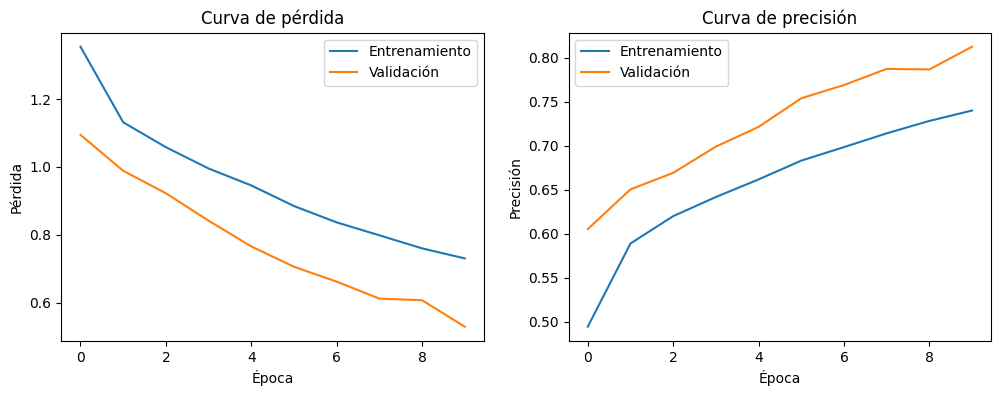

In [51]:
import matplotlib.pyplot as plt


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['sparse_categorical_accuracy']
val_accuracy = history2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [57]:
result = model2.evaluate(test_dataset_tensor)
print(result)

36/36 [==============================] - 60s 2s/step - loss: 0.5401 - sparse_categorical_accuracy: 0.8093
[0.5400736927986145, 0.8092588186264038]


In [68]:
next(iter(test_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2026, 2567, ...,    0,    0,    0],
         [ 101, 5271, 4319, ...,    0,    0,    0],
         [ 101, 1045, 1005, ...,    0,    0,    0],
         ...,
         [ 101, 1996, 3208, ...,    0,    0,    0],
         [ 101, 2035, 2204, ...,    0,    0,    0],
         [ 101, 4175, 2298, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([0, 1, 5, 3, 5, 5,

In [95]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


y_true = []
y_pred = []

for batch in test_dataset_tensor:
    inputs, labels = batch
    y_true.extend(labels.numpy())  # Extraer las etiquetas verdaderas
    y_pred_batch = model2.predict(inputs)  # Hacer predicciones en el lote actual
    y_pred.extend(np.argmax(y_pred_batch, axis=-1))  # Convertir las probabilidades a etiquetas y agregarlas a y_pred

# Convertir listas a arrays de NumPy
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

# Generar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_array, y_pred_array))

# Generar la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_true_array, y_pred_array))





1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.64      0.73       635
           1       0.90      0.90      0.90       635
           2       0.88      0.92      0.90       666
           3       0.87      0.67      0.75       640
           4       0.67      0.88      0.76       652
           5       0.80      0.71      0.75       632
           6       0.79      0.94      0.86       633

    accuracy                           0.81      4493
   macro avg       0.82      0.81      0.81      4493
weighted avg       0.82      0.81      0.81      4493

Confusion Matrix:
[[408  40  24  28  65  27  43]
 [ 11 569  20   1  10  19   5]
 [  2   4 612   3  21   8  16]
 [ 29   2  19 427  91  26  46]
 [  6   3   2  11 576  31  23]
 [ 25  14  19  18  80 450  26]
 [  2   3   3   5  17   5 598]]


In [70]:
from transformers import TFBertModel, BertTokenizer

def custom_objects_fn():
    return {'TFBertModel': TFBertModel}

model2 = load_model(r'model\BERTHugginfFace2\CNN\128batch\BERT_CNN_model_best_10_val_0.8124.h5', custom_objects=custom_objects_fn())
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_3[0][0]',            

In [95]:
resultNobalancing = model2.evaluate(dataset_NotBalancing_test)
print(resultNobalancing)

48/48 [==============================] - 75s 2s/step - loss: 0.6368 - sparse_categorical_accuracy: 0.7634
[0.6367922425270081, 0.7633891701698303]


In [71]:
resultNobalancing = model2.evaluate(dataset_NotBalancing_test)
print(resultNobalancing)

16/16 [==============================] - 34s 2s/step - loss: 0.6379 - sparse_categorical_accuracy: 0.7613
[0.6379419565200806, 0.7613127827644348]


## BERT + CNN con filters 128 filters

### Con randonOverSampler

In [63]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3Random = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3Random.layers[2].trainable=False

model3Random.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3Random.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [64]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace/CNNMoreFilters3Random/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNNMoreFilters3Random/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNNMoreFilters3Random/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNNMoreFilters3Random/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [65]:
history3Random = model3Random.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    983/Unknown - 874s 521ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.5455
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.64911, saving model to model/BERTHugginfFace/CNNMoreFilters3Random/32batch\BERT_CNN_model_best_01_val_0.6491.h5
983/983 [==============================] - 1333s 988ms/step - loss: 1.2443 - sparse_categorical_accuracy: 0.5455 - val_loss: 0.9787 - val_sparse_categorical_accuracy: 0.6491
Epoch 2/10
983/983 [==============================] - ETA: 0s - loss: 0.9743 - sparse_categorical_accuracy: 0.6538
Epoch 2: val_sparse_categorical_accuracy improved from 0.64911 to 0.73895, saving model to model/BERTHugginfFace/CNNMoreFilters3Random/32batch\BERT_CNN_model_best_02_val_0.7390.h5
983/983 [==============================] - 1216s 941ms/step - loss: 0.9743 - sparse_categorical_accuracy: 0.6538 - val_loss: 0.7361 - val_sparse_categorical_accuracy: 0.7390
Epoch 3/10
983/983 [==============================] - ETA: 0s - loss: 0.8196 - spa

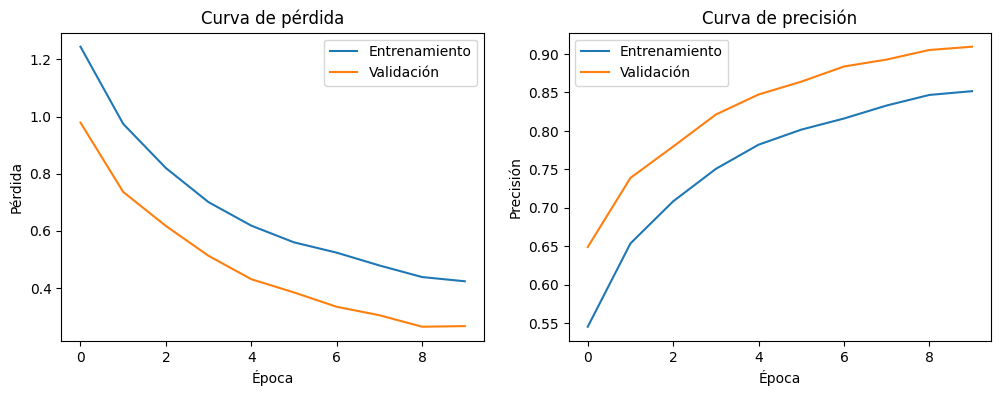

In [66]:
import matplotlib.pyplot as plt


train_loss = history3Random.history['loss']
val_loss = history3Random.history['val_loss']
train_accuracy = history3Random.history['sparse_categorical_accuracy']
val_accuracy = history3Random.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [67]:
result = model3Random.evaluate(test_dataset)


print("Result testeo", result)

141/141 [==============================] - 343s 455ms/step - loss: 0.2750 - sparse_categorical_accuracy: 0.9063
Result testeo [0.2750474512577057, 0.9062569737434387]


Dio un mejor valor pero puede presentar un sesgo al solo repetir valores

### Con Similitud

In [200]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3.layers[2].trainable=False

model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_9 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_39[0][0]',               
                                thPoolingAndCrossAt               'input_40[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [201]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace/CNNMoreFilters2/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/CNNMoreFilters2/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/CNNMoreFilters2/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/CNNMoreFilters2/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [202]:
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    983/Unknown - 1055s 522ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.5159
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61104, saving model to model/BERTHugginfFace/CNNMoreFilters2/32batch\BERT_CNN_model_best_01_val_0.6110.h5
983/983 [==============================] - 1524s 999ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.5159 - val_loss: 1.1042 - val_sparse_categorical_accuracy: 0.6110
Epoch 2/10
983/983 [==============================] - ETA: 0s - loss: 1.1225 - sparse_categorical_accuracy: 0.5958
Epoch 2: val_sparse_categorical_accuracy improved from 0.61104 to 0.65691, saving model to model/BERTHugginfFace/CNNMoreFilters2/32batch\BERT_CNN_model_best_02_val_0.6569.h5
983/983 [==============================] - 1202s 956ms/step - loss: 1.1225 - sparse_categorical_accuracy: 0.5958 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.6569
Epoch 3/10
983/983 [==============================] - ETA: 0s - loss: 1.0172 - sparse_categor

In [85]:
from transformers import TFBertModel,BertTokenizer

# Se Carga el modelo BERT de Hugging Face
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')


# Se Define la función custom_objects para cargar el modelo
def custom_objects_fn():
    return {'TFBertModel': bert_model}

model3 = load_model(r'E:\des\DATASET TEXT\model\BERTHugginfFace\CNNMoreFilters2\32batch\BERT_CNN_model_best_10_val_0.8407.h5', custom_objects=custom_objects_fn())
model3.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_39[0][0]',               
                                thPoolingAndCrossAt               'input_40[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [203]:
result = model3.evaluate(test_dataset)


print("Result testeo", result)

141/141 [==============================] - 354s 480ms/step - loss: 0.4549 - sparse_categorical_accuracy: 0.8419
Result testeo [0.45485785603523254, 0.8419060111045837]


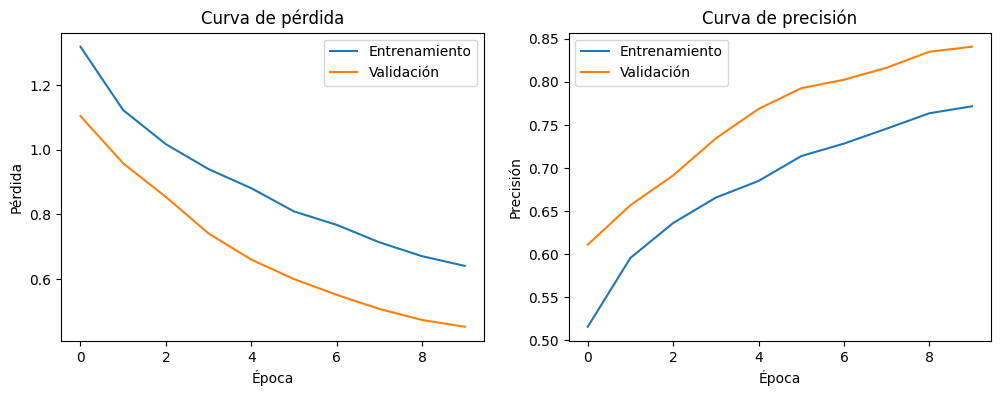

In [204]:
import matplotlib.pyplot as plt


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['sparse_categorical_accuracy']
val_accuracy = history3.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

Dio mas bajo que con RandomOverSampler, pero aún así no presenta el sesgo de los mismo datos repetidos, sino ocupa datos sinteticos y una mayor variabilidad de datos como en la realidad.

### Con tensores

In [117]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, token_type_ids=token_type_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3Tensores = tf.keras.models.Model(inputs=[input_ids_layer, token_type_ids_layer, attention_mask_layer], outputs=dense_output)

model3Tensores.layers[3].trainable=False

model3Tensores.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3Tensores.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_10[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]',         

In [53]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace2/CNN128filters/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace2/CNN128filters/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace2/CNN128filters/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace2/CNN128filters/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
historymodel3Tensores = model3Tensores.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - ETA: 0s - loss: 1.3908 - sparse_categorical_accuracy: 0.4907
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60448, saving model to model/BERTHugginfFace2/CNN128filters/128batch\BERT_CNN_model_best_01_val_0.6045.h5
246/246 [==============================] - 782s 3s/step - loss: 1.3908 - sparse_categorical_accuracy: 0.4907 - val_loss: 1.0878 - val_sparse_categorical_accuracy: 0.6045
Epoch 2/10
246/246 [==============================] - ETA: 0s - loss: 1.1417 - sparse_categorical_accuracy: 0.5819
Epoch 2: val_sparse_categorical_accuracy improved from 0.60448 to 0.64867, saving model to model/BERTHugginfFace2/CNN128filters/128batch\BERT_CNN_model_best_02_val_0.6487.h5
246/246 [==============================] - 659s 3s/step - loss: 1.1417 - sparse_categorical_accuracy: 0.5819 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.6487
Epoch 3/10
246/246 [==============================] - ETA: 0s - loss: 1.0463 - sparse

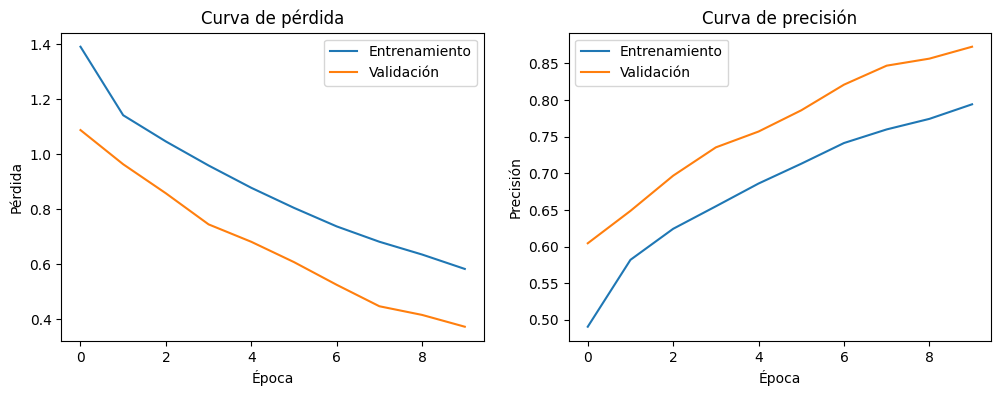

In [55]:
import matplotlib.pyplot as plt


train_loss = historymodel3Tensores.history['loss']
val_loss = historymodel3Tensores.history['val_loss']
train_accuracy = historymodel3Tensores.history['sparse_categorical_accuracy']
val_accuracy = historymodel3Tensores.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [56]:
result = model3Tensores.evaluate(test_dataset_tensor)
print(result)

36/36 [==============================] - 57s 2s/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8778
[0.36368095874786377, 0.8778099417686462]


In [96]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for batch in test_dataset_tensor:
    inputs, labels = batch
    y_true.extend(labels.numpy())  # Extraer las etiquetas verdaderas
    y_pred_batch = model3Tensores.predict(inputs)  # Hacer predicciones en el lote actual
    y_pred.extend(np.argmax(y_pred_batch, axis=-1))  # Convertir las probabilidades a etiquetas y agregarlas a y_pred

# Convertir listas a arrays de NumPy
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

# Generar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_array, y_pred_array))

# Generar la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_true_array, y_pred_array))


1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       616
           1       0.94      0.94      0.94       674
           2       0.97      0.96      0.96       662
           3       0.87      0.79      0.83       638
           4       0.78      0.89      0.83       629
           5       0.90      0.79      0.84       648
           6       0.87      0.93      0.90       626

    accuracy                           0.88      4493
   macro avg       0.88      0.88      0.87      4493
weighted avg       0.88      0.88      0.88      4493

Confusion Matrix:
[[517   8   4  19  34   7  27]
 [ 24 633   4   6   3   1   3]
 [  5   2 633   4   5   7   6]
 [ 35   5   0 503  51  22  22]
 [ 11   1   1  26 557  17  16]
 [ 32  20   8  10  56 509  13]
 [  9   3   5  11  11   2 585]]


In [73]:
from transformers import TFBertModel, BertTokenizer

def custom_objects_fn():
    return {'TFBertModel': TFBertModel}

model3 = load_model(r'model\BERTHugginfFace2\CNN128filters\128batch\BERT_CNN_model_best_10_val_0.8725.h5', custom_objects=custom_objects_fn())
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]',          

In [96]:
resultNobalancing2 = model3.evaluate(dataset_NotBalancing_test)
print(resultNobalancing2)

48/48 [==============================] - 77s 2s/step - loss: 0.4741 - sparse_categorical_accuracy: 0.8327
[0.4741077423095703, 0.8326977491378784]


In [99]:
result = model3.evaluate(test_dataset_tensor)
print(result)

36/36 [==============================] - 58s 2s/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8705
[0.37926027178764343, 0.8704651594161987]


In [77]:
# Extraer los datos y las etiquetas verdaderas del conjunto de prueba
y_true = []
y_pred = []

for batch in dataset_NotBalancing_test:
    inputs, labels = batch
    y_true.extend(labels.numpy())  # Extraer las etiquetas verdaderas
    y_pred_batch = model3.predict(inputs)  # Hacer predicciones en el lote actual
    y_pred.extend(np.argmax(y_pred_batch, axis=-1))  # Convertir las probabilidades a etiquetas y agregarlas a y_pred

# Convertir listas a arrays de NumPy
y_true_array2 = np.array(y_true)
y_pred_array2 = np.array(y_pred)

# Generar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_array2, y_pred_array2))

3/3 [==============================] - 4s 408ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       318
           1       0.89      0.90      0.89       139
           2       0.92      0.92      0.92       149
           3       0.83      0.76      0.79       322
           4       0.83      0.88      0.85       679
           5       0.88      0.74      0.80       272
           6       0.74      0.90      0.81       132

    accuracy                           0.84      2011
   macro avg       0.84      0.84      0.84      2011
weighted avg       0.84      0.84      0.84      2011



In [178]:
sentence_test = "yesterday i be just about to cross the road when a country guy who be ahead of me spat out a mouthful of betel juice on the road. it be very windy and have i not check my speed i would have have a very good shower of his saliva. though i be not angry i felt that these people be very indecent."

input_sentence_test = tokenizer_bert(sentence_test,
                                     padding='max_length',
                                     truncation=True,
                                     max_length=300,
                                     return_tensors='tf')

In [179]:
input_ids_test = input_sentence_test['input_ids']
token_type_ids_test = input_sentence_test['token_type_ids']
attention_mask_test = input_sentence_test['attention_mask']

In [185]:
prediction = model3Tensores.predict([input_ids_test, token_type_ids_test, attention_mask_test])
prediction_clases = np.argmax(prediction)

print(prediction)
print(prediction_clases)

if prediction_clases == 0:
    print('angry')
if prediction_clases == 1:
    print('disgust')
if prediction_clases == 2:
    print('fear')
if prediction_clases == 3:
    print('happy')
if prediction_clases == 4:
    print('neutral')
if prediction_clases == 5:
    print('sad')
if prediction_clases == 6:
    print('surprise')

1/1 [==============================] - 0s 73ms/step
[[0.11550854 0.01592919 0.272611   0.03294307 0.10117099 0.4088467
  0.0529905 ]]
5
sad


### Con divisiones

In [80]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3Divisiones = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3Divisiones.layers[2].trainable=False

model3Divisiones.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3Divisiones.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_13[0][0]',               
                                thPoolingAndCrossAt               'input_14[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [111]:
historymodel3Divisiones = model3Divisiones.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 645s 2s/step - loss: 1.3715 - sparse_categorical_accuracy: 0.4948 - val_loss: 1.1384 - val_sparse_categorical_accuracy: 0.5840
Epoch 2/10
246/246 [==============================] - 563s 2s/step - loss: 1.1281 - sparse_categorical_accuracy: 0.5905 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.6283
Epoch 3/10
246/246 [==============================] - 563s 2s/step - loss: 1.0112 - sparse_categorical_accuracy: 0.6372 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.6529
Epoch 4/10
246/246 [==============================] - 563s 2s/step - loss: 0.9054 - sparse_categorical_accuracy: 0.6802 - val_loss: 0.8939 - val_sparse_categorical_accuracy: 0.6806
Epoch 5/10
246/246 [==============================] - 563s 2s/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.8657 - val_sparse_categorical_accuracy: 0.6964
Epoch 6/10
246/246 [==============================] - 563s 2s/step - loss: 0.7187 - sparse_cate

In [81]:
historymodel3Divisiones = model3Divisiones.fit( #sin lematizacion
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 613s 2s/step - loss: 1.3410 - sparse_categorical_accuracy: 0.5069 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.6115
Epoch 2/10
246/246 [==============================] - 601s 2s/step - loss: 1.0919 - sparse_categorical_accuracy: 0.6074 - val_loss: 1.0097 - val_sparse_categorical_accuracy: 0.6281
Epoch 3/10
246/246 [==============================] - 600s 2s/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6546 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.6702
Epoch 4/10
246/246 [==============================] - 596s 2s/step - loss: 0.8605 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.8678 - val_sparse_categorical_accuracy: 0.6891
Epoch 5/10
246/246 [==============================] - 598s 2s/step - loss: 0.7599 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.8213 - val_sparse_categorical_accuracy: 0.7112
Epoch 6/10
246/246 [==============================] - 600s 2s/step - loss: 0.6635 - sparse_cate

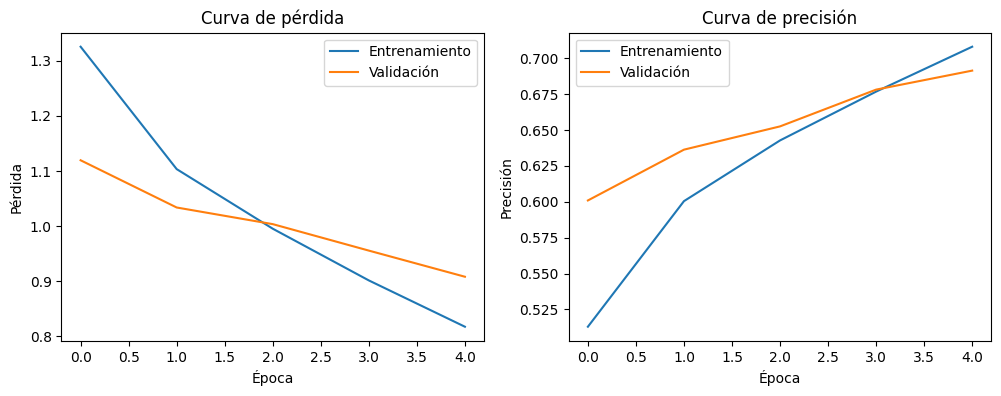

In [128]:
import matplotlib.pyplot as plt


train_loss = historymodel3Divisiones.history['loss']
val_loss = historymodel3Divisiones.history['val_loss']
train_accuracy = historymodel3Divisiones.history['sparse_categorical_accuracy']
val_accuracy = historymodel3Divisiones.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [127]:
result_meld = model3Divisiones.evaluate(dataset_meld_test)
print(result_meld)


result_iemocap = model3Divisiones.evaluate(dataset_iemocap_test)
print(result_iemocap)

82/82 [==============================] - 53s 641ms/step - loss: 1.3892 - sparse_categorical_accuracy: 0.5625
[1.3891942501068115, 0.5624520778656006]
145/145 [==============================] - 95s 650ms/step - loss: 0.8476 - sparse_categorical_accuracy: 0.6897
[0.8476039171218872, 0.6896700263023376]


### Sin MELD

In [27]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3Divisiones2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model3Divisiones2.layers[2].trainable=False

model3Divisiones2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3Divisiones2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [28]:
historymodel3Divisiones2 = model3Divisiones2.fit(
    dataset_tensors_train,
    validation_data=dataset_tensors_val,
    epochs=10
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10


347/347 [==============================] - 305s 693ms/step - loss: 1.2233 - sparse_categorical_accuracy: 0.5448 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.6813
Epoch 2/10
347/347 [==============================] - 218s 628ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.6924 - val_loss: 0.7632 - val_sparse_categorical_accuracy: 0.7182
Epoch 3/10
347/347 [==============================] - 218s 628ms/step - loss: 0.7216 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.7549 - val_sparse_categorical_accuracy: 0.7221
Epoch 4/10
347/347 [==============================] - 217s 627ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.7722 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.7618
Epoch 5/10
347/347 [==============================] - 217s 626ms/step - loss: 0.5308 - sparse_categorical_accuracy: 0.8069 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.7791
Epoch 6/10
347/347 [==============================] - 217s 627ms/step - loss: 0.4537 - spar

### Con Tokens_type_ids

In [42]:
inputs

{'input_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[ 101, 2036, 1045, ...,    0,    0,    0],
       [ 101, 2017, 2442, ...,    0,    0,    0],
       [ 101, 2008, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 2017, 1005, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       [ 101, 1037, 2158, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(44919, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [67]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, token_type_ids=token_type_ids_layer, attention_mask=attention_mask_layer)[0]
x_1 = tf.keras.layers.Conv1D(128,2,padding='same', activation='relu')(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128,3,padding='same', activation='relu')(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128,4,padding='same', activation='relu')(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
merged = tf.concat([x_1,x_2,x_3], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model3Divisiones2 = tf.keras.models.Model(inputs=[input_ids_layer, token_type_ids_layer, attention_mask_layer], outputs=dense_output)

model3Divisiones2.layers[3].trainable=False

model3Divisiones2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model3Divisiones2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_10[0][0]',               
                                thPoolingAndCrossAt               'input_12[0][0]',         

In [48]:
next(iter(train_dataset_tensor.take(1)))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[ 101, 2065, 2057, ...,    0,    0,    0],
         [ 101, 1045, 4374, ...,    0,    0,    0],
         [ 101, 1996, 2154, ...,    0,    0,    0],
         ...,
         [ 101, 1059, 2232, ...,    0,    0,    0],
         [ 101, 2821, 2053, ...,    0,    0,    0],
         [ 101, 2016, 2022, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([3, 3, 2, 2, 6, 5,

In [47]:
historymodel3Divisiones2 = model3Divisiones2.fit( #con lematizacion
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 617s 2s/step - loss: 1.3794 - sparse_categorical_accuracy: 0.4901 - val_loss: 1.0961 - val_sparse_categorical_accuracy: 0.6015
Epoch 2/10
246/246 [==============================] - 596s 2s/step - loss: 1.1500 - sparse_categorical_accuracy: 0.5822 - val_loss: 0.9766 - val_sparse_categorical_accuracy: 0.6492
Epoch 3/10
246/246 [==============================] - 597s 2s/step - loss: 1.0454 - sparse_categorical_accuracy: 0.6240 - val_loss: 0.8978 - val_sparse_categorical_accuracy: 0.6786
Epoch 4/10
246/246 [==============================] - 599s 2s/step - loss: 0.9627 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.7655 - val_sparse_categorical_accuracy: 0.7324
Epoch 5/10
246/246 [==============================] - 606s 2s/step - loss: 0.8795 - sparse_categorical_accuracy: 0.6875 - val_loss: 0.6402 - val_sparse_categorical_accuracy: 0.7732
Epoch 6/10
246/246 [==============================] - 610s 2s/step - loss: 0.8087 - sparse_cate

In [68]:
historymodel3Divisiones2 = model3Divisiones2.fit( #Sin Lemmatización
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 628s 2s/step - loss: 1.3590 - sparse_categorical_accuracy: 0.5018 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.6075
Epoch 2/10
246/246 [==============================] - 622s 3s/step - loss: 1.1028 - sparse_categorical_accuracy: 0.6015 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.6585
Epoch 3/10
246/246 [==============================] - 602s 2s/step - loss: 0.9987 - sparse_categorical_accuracy: 0.6393 - val_loss: 0.8407 - val_sparse_categorical_accuracy: 0.7012
Epoch 4/10
246/246 [==============================] - 597s 2s/step - loss: 0.9130 - sparse_categorical_accuracy: 0.6736 - val_loss: 0.7337 - val_sparse_categorical_accuracy: 0.7404
Epoch 5/10
246/246 [==============================] - 599s 2s/step - loss: 0.8259 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.7784
Epoch 6/10
246/246 [==============================] - 597s 2s/step - loss: 0.7525 - sparse_cate

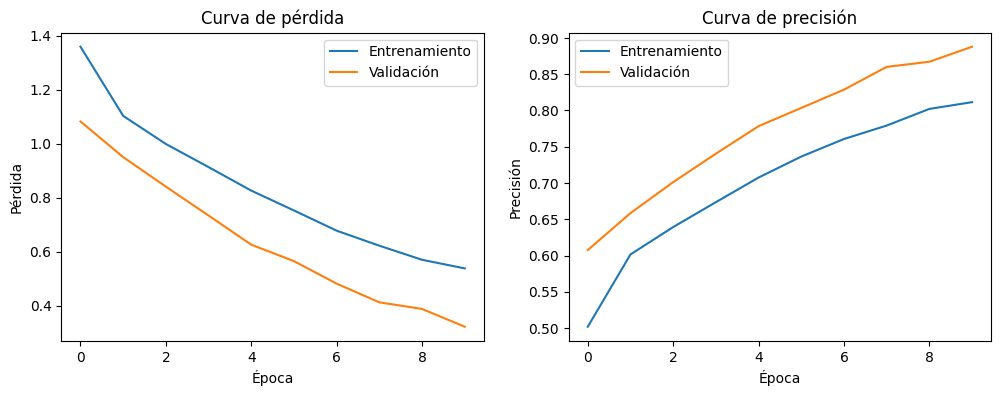

In [83]:
import matplotlib.pyplot as plt


train_loss = historymodel3Divisiones2.history['loss']
val_loss = historymodel3Divisiones2.history['val_loss']
train_accuracy = historymodel3Divisiones2.history['sparse_categorical_accuracy']
val_accuracy = historymodel3Divisiones2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [95]:
sentence_test = "also i was the point person on my company's transition from the kl to gr system."

input_sentence_test = tokenizer_bert(sentence_test,
                                     padding='max_length',
                                     truncation=True,
                                     max_length=300,
                                     return_tensors='tf')




In [96]:
input_sentence_test

{'input_ids': <tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,
         2194,  1005,  1055,  6653,  2013,  1996,  1047,  2140,  2000,
        24665,  2291,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [97]:
input_ids_test = input_sentence_test['input_ids']
token_type_ids_test = input_sentence_test['token_type_ids']
attention_mask_test = input_sentence_test['attention_mask']

In [98]:
input_ids_test

<tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,
         2194,  1005,  1055,  6653,  2013,  1996,  1047,  2140,  2000,
        24665,  2291,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [99]:
token_type_ids_test

<tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [100]:
attention_mask_test

<tf.Tensor: shape=(1, 300), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [101]:
texto_clean[0]

"also i was the point person on my company's transition from the kl to gr system."

In [102]:
data_labels[0]

4

In [103]:
prediction = model3Divisiones2.predict([input_ids_test, token_type_ids_test, attention_mask_test])
prediction_clases = np.argmax(prediction)

print(prediction)
print(prediction_clases)

if prediction_clases == 0:
    print('angry')
if prediction_clases == 1:
    print('disgust')
if prediction_clases == 2:
    print('fear')
if prediction_clases == 3:
    print('happy')
if prediction_clases == 4:
    print('neutral')
if prediction_clases == 5:
    print('sad')
if prediction_clases == 6:
    print('surprise')

1/1 [==============================] - 0s 313ms/step
[[1.3999420e-01 3.5643847e-05 3.1078143e-05 3.7719481e-02 7.9166257e-01
  3.0426387e-02 1.3058184e-04]]
4
neutral


In [106]:
next(iter(test_dataset_tensor))

((<tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[  101, 10131, 17683, ...,     0,     0,     0],
         [  101,  1045,  7861, ...,     0,     0,     0],
         [  101, 23281,   999, ...,     0,     0,     0],
         ...,
         [  101,  3398,  1012, ...,     0,     0,     0],
         [  101,  2057,  4839, ...,     0,     0,     0],
         [  101,  4283,  1012, ...,     0,     0,     0]])>,
  <tf.Tensor: shape=(128, 300), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>),
 <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([3, 0, 6, 4, 0, 3, 4, 2, 5, 5, 4, 6, 2, 6, 4, 6, 2, 3, 2, 1, 6, 2,
        1, 3, 3, 5, 1, 2, 5, 6, 3, 3, 2, 1, 0, 6, 5, 2, 1, 4, 4, 0, 0, 6,
        4, 3, 3, 3, 6, 5, 6, 6, 5, 2, 2, 1, 2, 5, 0, 6, 5, 3, 3, 0, 2, 6,
        2, 4, 0, 5, 1, 0, 6, 4, 4, 1, 4,

In [111]:
evaluate_test = model3Divisiones2.evaluate(test_dataset_tensor)
evaluate_test

36/36 [==============================] - 58s 2s/step - loss: 0.3236 - sparse_categorical_accuracy: 0.8843


[0.32356008887290955, 0.8842644095420837]

## Duo Channel

In [124]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, token_type_ids=token_type_ids_layer, attention_mask=attention_mask_layer)[0]

x_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(bert_output)
x_conv1 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(x_lstm)
x_dropout=tf.keras.layers.Dropout(0.5)(x_conv1)


x_conv2 = tf.keras.layers.Conv1D(64,3,padding='same', activation='relu')(bert_output)
x_dropout2=tf.keras.layers.Dropout(0.5)(x_conv2)
x_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x_dropout2)


merged = tf.concat([x_conv1,x_lstm2], axis=-1)
x = tf.keras.layers.MaxPooling1D()(merged)
#x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(x)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model4 = tf.keras.models.Model(inputs=[input_ids_layer, token_type_ids_layer, attention_mask_layer], outputs=dense_output)

model4.layers[3].trainable=False
# Compila el modelo
model4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_13[0][0]',               
                                thPoolingAndCrossAt               'input_15[0][0]',         

In [126]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace2/DuoChannel/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace2/DuoChannel/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace2/DuoChannel/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace2/DuoChannel/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [127]:
history4 = model4.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - ETA: 0s - loss: 1.4786 - sparse_categorical_accuracy: 0.4750
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56629, saving model to model/BERTHugginfFace2/DuoChannel/128batch\BERT_CNN_model_best_01_val_0.5663.h5
246/246 [==============================] - 640s 3s/step - loss: 1.4786 - sparse_categorical_accuracy: 0.4750 - val_loss: 1.1979 - val_sparse_categorical_accuracy: 0.5663
Epoch 2/10
246/246 [==============================] - ETA: 0s - loss: 1.2267 - sparse_categorical_accuracy: 0.5560
Epoch 2: val_sparse_categorical_accuracy improved from 0.56629 to 0.59067, saving model to model/BERTHugginfFace2/DuoChannel/128batch\BERT_CNN_model_best_02_val_0.5907.h5
246/246 [==============================] - 615s 3s/step - loss: 1.2267 - sparse_categorical_accuracy: 0.5560 - val_loss: 1.1233 - val_sparse_categorical_accuracy: 0.5907
Epoch 3/10
246/246 [==============================] - ETA: 0s - loss: 1.1530 - sparse_categ

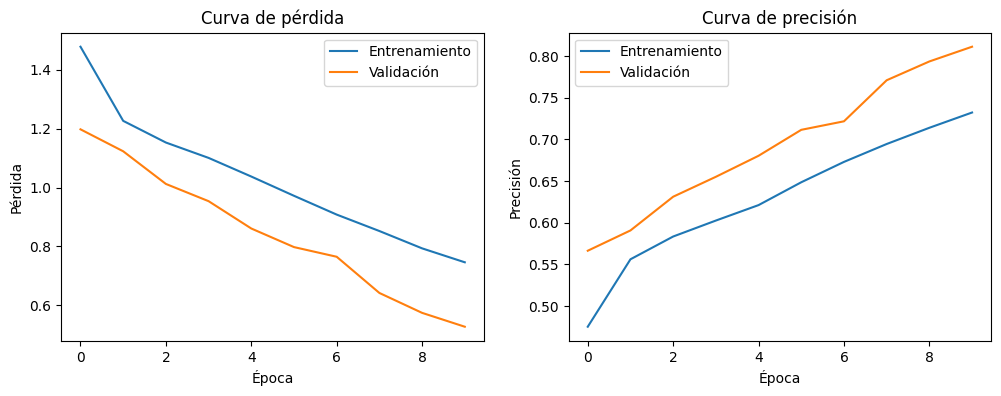

In [129]:
import matplotlib.pyplot as plt


train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
train_accuracy = history4.history['sparse_categorical_accuracy']
val_accuracy = history4.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [130]:
result = model4.evaluate(test_dataset_tensor)
result

36/36 [==============================] - 59s 2s/step - loss: 0.5233 - sparse_categorical_accuracy: 0.8106


[0.523341715335846, 0.8105942606925964]

In [133]:
y_true = []
y_pred = []

for batch in test_dataset_tensor:
    inputs_batch, labels_batch = batch
    y_true.extend(labels_batch.numpy())
    y_pred_probs = model4.predict(inputs_batch)
    y_pred.extend(np.argmax(y_pred_probs, axis=-1))


y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

# Generar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_array, y_pred_array))

# Generar la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_true_array, y_pred_array))

1/1 [==============================] - 5s 5s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       636
           1       0.86      0.94      0.90       626
           2       0.94      0.91      0.92       644
           3       0.72      0.76      0.74       647
           4       0.68      0.83      0.75       637
           5       0.85      0.64      0.73       655
           6       0.83      0.91      0.87       648

    accuracy                           0.81      4493
   macro avg       0.82      0.81      0.81      4493
weighted avg       0.82      0.81      0.81      4493

Confusion Matrix:
[[436  46   9  36  51  17  41]
 [  9 587   7  12   3   5   3]
 [  5  13 584  16   8  12   6]
 [ 23  14   6 489  78  18  19]
 [ 21   2   1  41 529  20  23]
 [ 26  21  11  57  92 421  27]
 [ 11   0   2  27  16   3 589]]


## BERT + BILSTM

In [135]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, token_type_ids=token_type_ids_layer, attention_mask=attention_mask_layer)[0]

x_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True))(bert_output)


#merged = tf.concat([x_conv1,x_lstm2], axis=-1)
x = tf.keras.layers.GlobalMaxPooling1D()(x_lstm)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Flatten()(x)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(x)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model5 = tf.keras.models.Model(inputs=[input_ids_layer, token_type_ids_layer, attention_mask_layer], outputs=dense_output)

model5.layers[3].trainable=False
# Compila el modelo
model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_19[0][0]',               
                                thPoolingAndCrossAt               'input_21[0][0]',         

In [136]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace2/BiLstm/128batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace2/BiLstm/128batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace2/BiLstm/128batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace2/BiLstm/128batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [137]:
history5 = model5.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - ETA: 0s - loss: 1.3382 - sparse_categorical_accuracy: 0.5048
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.59757, saving model to model/BERTHugginfFace2/BiLstm/128batch\BERT_CNN_model_best_01_val_0.5976.h5
246/246 [==============================] - 689s 3s/step - loss: 1.3382 - sparse_categorical_accuracy: 0.5048 - val_loss: 1.0999 - val_sparse_categorical_accuracy: 0.5976
Epoch 2/10
246/246 [==============================] - ETA: 0s - loss: 1.1171 - sparse_categorical_accuracy: 0.5933
Epoch 2: val_sparse_categorical_accuracy improved from 0.59757 to 0.65680, saving model to model/BERTHugginfFace2/BiLstm/128batch\BERT_CNN_model_best_02_val_0.6568.h5
246/246 [==============================] - 665s 3s/step - loss: 1.1171 - sparse_categorical_accuracy: 0.5933 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.6568
Epoch 3/10
246/246 [==============================] - ETA: 0s - loss: 1.0225 - sparse_categorical_a

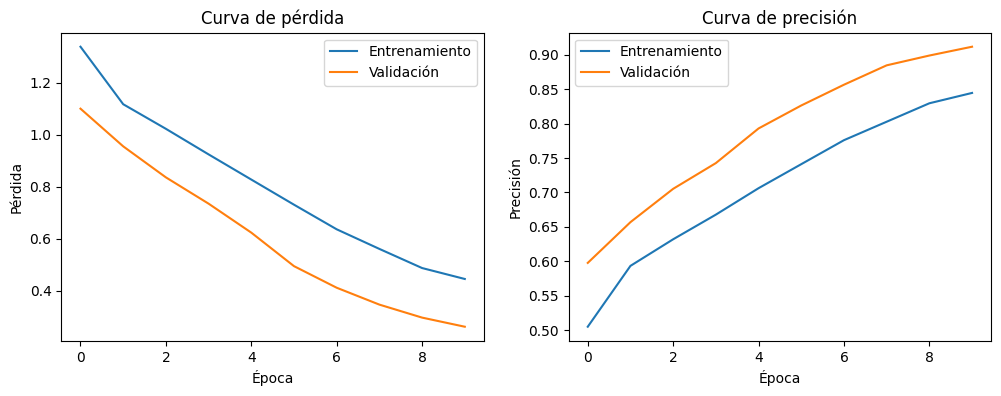

In [138]:
import matplotlib.pyplot as plt


train_loss = history5.history['loss']
val_loss = history5.history['val_loss']
train_accuracy = history5.history['sparse_categorical_accuracy']
val_accuracy = history5.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [139]:
result = model5.evaluate(test_dataset_tensor)
result

36/36 [==============================] - 62s 2s/step - loss: 0.2521 - sparse_categorical_accuracy: 0.9130


[0.25207164883613586, 0.9129757285118103]

In [140]:
y_true = []
y_pred = []

for batch in test_dataset_tensor:
    inputs_batch, labels_batch = batch
    y_true.extend(labels_batch.numpy())
    y_pred_probs = model5.predict(inputs_batch)
    y_pred.extend(np.argmax(y_pred_probs, axis=-1))


y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

# Generar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_true_array, y_pred_array))

# Generar la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_true_array, y_pred_array))

1/1 [==============================] - 4s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       626
           1       0.93      0.98      0.96       629
           2       0.98      0.96      0.97       663
           3       0.90      0.88      0.89       642
           4       0.81      0.92      0.86       656
           5       0.95      0.85      0.89       649
           6       0.91      0.96      0.93       628

    accuracy                           0.91      4493
   macro avg       0.92      0.91      0.91      4493
weighted avg       0.92      0.91      0.91      4493

Confusion Matrix:
[[530  19   2  14  33   9  19]
 [  1 617   1   4   4   1   1]
 [  3   9 636   3   1   3   8]
 [  6   0   2 565  51   3  15]
 [ 11   0   1  20 601  13  10]
 [ 12  15   5  12  47 549   9]
 [  4   2   0  13   6   1 602]]


In [124]:
history5 = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    983/Unknown - 969s 611ms/step - loss: 1.2923 - sparse_categorical_accuracy: 0.5234
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.62095, saving model to model/BERTHugginfFace/BertBiLSTM/32batch\BERT_CNN_model_best_01_val_0.6210.h5
983/983 [==============================] - 1434s 1s/step - loss: 1.2923 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.0600 - val_sparse_categorical_accuracy: 0.6210
Epoch 2/10
983/983 [==============================] - ETA: 0s - loss: 1.0789 - sparse_categorical_accuracy: 0.6111
Epoch 2: val_sparse_categorical_accuracy improved from 0.62095 to 0.68474, saving model to model/BERTHugginfFace/BertBiLSTM/32batch\BERT_CNN_model_best_02_val_0.6847.h5
983/983 [==============================] - 1299s 1s/step - loss: 1.0789 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.8869 - val_sparse_categorical_accuracy: 0.6847
Epoch 3/10
983/983 [==============================] - ETA: 0s - loss: 0.9575 - sparse_categorical_accuracy: 0.

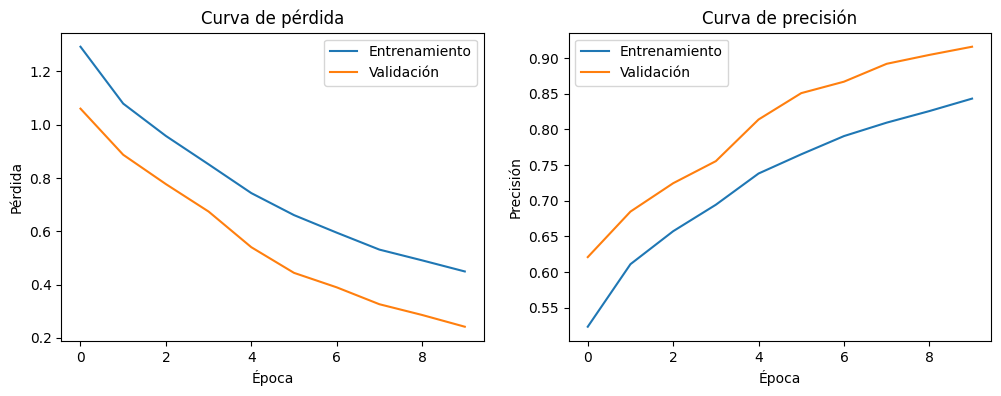

In [125]:
import matplotlib.pyplot as plt


train_loss = history5.history['loss']
val_loss = history5.history['val_loss']
train_accuracy = history5.history['sparse_categorical_accuracy']
val_accuracy = history5.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [35]:
def custom_objects_fn():
    return {'TFBertModel':TFBertModel}

model5 = load_model(r'E:\des\DATASET TEXT\model\BERTHugginfFace\BertBiLSTM\32batch\BERT_CNN_model_best_10_val_0.9157.h5', custom_objects=custom_objects_fn())
model5.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [36]:
result = model5.evaluate(test_dataset)
print(result)

141/141 [==============================] - 390s 515ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.9109
[0.25203850865364075, 0.9109329581260681]


In [51]:
result_meld = model5.evaluate(dataset_meld_test)
print(result_meld)


result_iemocap = model5.evaluate(dataset_iemocap_test)
print(result_iemocap)

82/82 [==============================] - 58s 693ms/step - loss: 1.4994 - sparse_categorical_accuracy: 0.5812
[1.4994430541992188, 0.5812260508537292]
145/145 [==============================] - 103s 707ms/step - loss: 0.4058 - sparse_categorical_accuracy: 0.8467
[0.4058268666267395, 0.8466681241989136]


Con tensores train,test,val

In [89]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True))(bert_output)


#merged = tf.concat([x_conv1,x_lstm2], axis=-1)
x = tf.keras.layers.GlobalMaxPooling1D()(x_lstm)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Flatten()(x)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(x)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model5_2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model5_2.layers[2].trainable=False
# Compila el modelo
model5_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model5_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [90]:
historymodel5_2 = model5_2.fit(
    dataset_tensors_train,
    validation_data=dataset_tensors_val,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
1011/1011 [==============================] - 871s 781ms/step - loss: 1.2903 - sparse_categorical_accuracy: 0.5279 - val_loss: 1.1024 - val_sparse_categorical_accuracy: 0.5977
Epoch 2/10
1011/1011 [==============================] - 761s 752ms/step - loss: 1.0719 - sparse_categorical_accuracy: 0.6146 - val_loss: 0.9725 - val_sparse_categorical_accuracy: 0.6506
Epoch 3/10
1011/1011 [==============================] - 757s 748ms/step - loss: 0.9333 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.6668
Epoch 4/10
1011/1011 [==============================] - 755s 747ms/step - loss: 0.7999 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.8857 - val_sparse_categorical_accuracy: 0.6981
Epoch 5/10
1011/1011 [==============================] - 762s 754ms/step - loss: 0.6780 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.8006 - val_sparse_categorical_accuracy: 0.7251
Epoch 6/10
1011/1011 [==============================] - 764s 755ms/ste

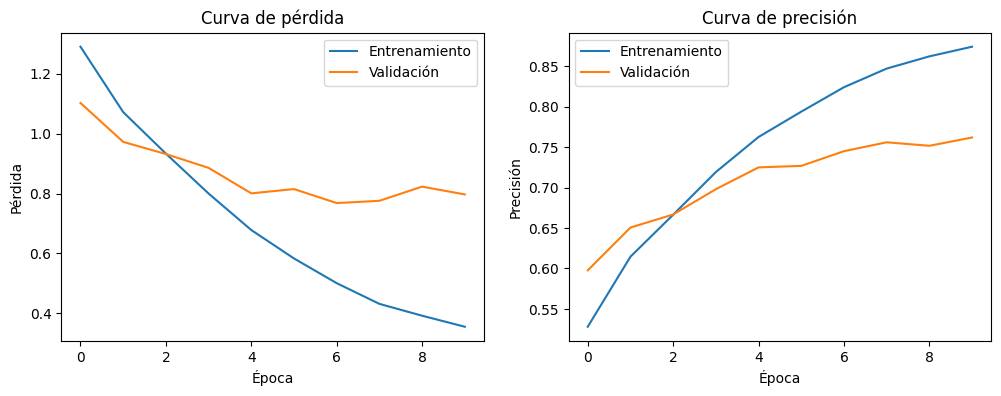

In [91]:
import matplotlib.pyplot as plt


train_loss = historymodel5_2.history['loss']
val_loss = historymodel5_2.history['val_loss']
train_accuracy = historymodel5_2.history['sparse_categorical_accuracy']
val_accuracy = historymodel5_2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## BERT + CNN + Bi LSTM

In [52]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768, return_sequences=True))(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(128, 2,activation="relu")(bert_output)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128, 3,activation="relu")(bert_output)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(128, 4,activation="relu")(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)

merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model6 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model6.layers[2].trainable=False
# Compila el modelo
model6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [53]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace/BertCNNBILSTM/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/BertCNNBILSTM/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/BertCNNBILSTM/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/BertCNNBILSTM/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [54]:
history6 = model6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    983/Unknown - 981s 640ms/step - loss: 1.3076 - sparse_categorical_accuracy: 0.5203
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61839, saving model to model/BERTHugginfFace/BertCNNBILSTM/32batch\BERT_CNN_model_best_01_val_0.6184.h5
983/983 [==============================] - 1462s 1s/step - loss: 1.3076 - sparse_categorical_accuracy: 0.5203 - val_loss: 1.0487 - val_sparse_categorical_accuracy: 0.6184
Epoch 2/10
983/983 [==============================] - ETA: 0s - loss: 1.0867 - sparse_categorical_accuracy: 0.6089
Epoch 2: val_sparse_categorical_accuracy improved from 0.61839 to 0.67528, saving model to model/BERTHugginfFace/BertCNNBILSTM/32batch\BERT_CNN_model_best_02_val_0.6753.h5
983/983 [==============================] - 1367s 1s/step - loss: 1.0867 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.8915 - val_sparse_categorical_accuracy: 0.6753
Epoch 3/10
983/983 [==============================] - ETA: 0s - loss: 0.9702 - sparse_categorical_accura

In [57]:
result = model6.evaluate(test_dataset)
print(result)

141/141 [==============================] - 361s 524ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.9011
[0.28938430547714233, 0.9011356234550476]


In [56]:
result_meld = model6.evaluate(dataset_meld_test)
print(result_meld)


result_iemocap = model6.evaluate(dataset_iemocap_test)
print(result_iemocap)

82/82 [==============================] - 58s 703ms/step - loss: 1.4567 - sparse_categorical_accuracy: 0.5839
[1.45671808719635, 0.5839080214500427]
145/145 [==============================] - 102s 701ms/step - loss: 0.4447 - sparse_categorical_accuracy: 0.8329
[0.4447150230407715, 0.8328660726547241]


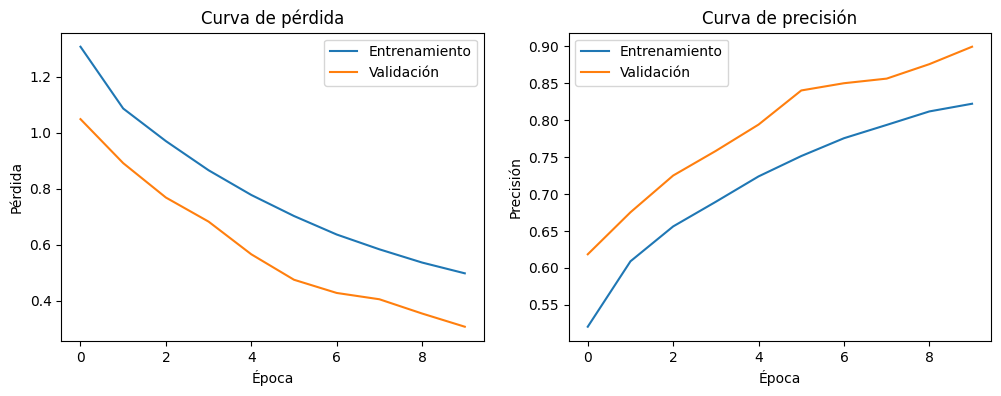

In [55]:
import matplotlib.pyplot as plt


train_loss = history6.history['loss']
val_loss = history6.history['val_loss']
train_accuracy = history6.history['sparse_categorical_accuracy']
val_accuracy = history6.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

## BERT + CNN + MultiHeadAttention

In [105]:

input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_2 = tf.keras.layers.Conv1D(128, 2,activation="relu")(bert_output)
x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(128, 3,activation="relu")(bert_output)
x_3 = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(128, 4,activation="relu")(bert_output)
x_4 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=128)(x_4,x_4)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.5)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7.layers[2].trainable=False
# Compila el modelo
model7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_27[0][0]',               
                                thPoolingAndCrossAt               'input_28[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [106]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERTHugginfFace/BertCNNMultiHeadAttention/32batch', exist_ok=True)


checkpoint_path = 'model/BERTHugginfFace/BertCNNMultiHeadAttention/32batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='hdf5',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERTHugginfFace/BertCNNMultiHeadAttention/32batch', exist_ok=True)



log_dir = "logs/BERTHugginfFace/BertCNNMultiHeadAttention/32batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
history7 = model7.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
983/983 [==============================] - ETA: 0s - loss: 1.3278 - sparse_categorical_accuracy: 0.5156
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.58789, saving model to model/BERTHugginfFace/BertCNNMultiHeadAttention/32batch\BERT_CNN_model_best_01_val_0.5879.h5
983/983 [==============================] - 770s 706ms/step - loss: 1.3278 - sparse_categorical_accuracy: 0.5156 - val_loss: 1.1396 - val_sparse_categorical_accuracy: 0.5879
Epoch 2/10
983/983 [==============================] - ETA: 0s - loss: 1.1808 - sparse_categorical_accuracy: 0.5749
Epoch 2: val_sparse_categorical_accuracy improved from 0.58789 to 0.60036, saving model to model/BERTHugginfFace/BertCNNMultiHeadAttention/32batch\BERT_CNN_model_best_02_val_0.6004.h5
983/983 [==============================] - 666s 677ms/step - loss: 1.1808 - sparse_categorical_accuracy: 0.5749 - val_loss: 1.1040 - val_sparse_categorical_accuracy: 0.6004
Epoch 3/10
983/983 [==============================] - ETA: 

In [110]:
result_meld = model7.evaluate(dataset_meld_test)
print(result_meld)


result_iemocap = model7.evaluate(dataset_iemocap_test)
print(result_iemocap)

82/82 [==============================] - 55s 661ms/step - loss: 1.2826 - sparse_categorical_accuracy: 0.5923
[1.2825552225112915, 0.5923371911048889]
145/145 [==============================] - 96s 659ms/step - loss: 0.8317 - sparse_categorical_accuracy: 0.6903
[0.8316577076911926, 0.6903170347213745]


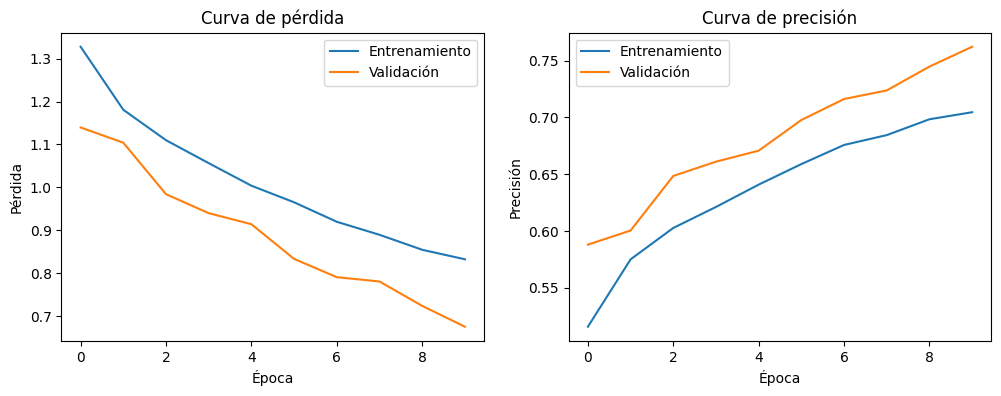

In [108]:
import matplotlib.pyplot as plt


train_loss = history7.history['loss']
val_loss = history7.history['val_loss']
train_accuracy = history7.history['sparse_categorical_accuracy']
val_accuracy = history7.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [186]:

input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_2 = tf.keras.layers.Conv1D(64, 2,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64, 3,activation="relu")(bert_output)
#x_3 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64, 4,activation="relu")(bert_output)
#x_4 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_4,x_4)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.25)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7_2 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7_2.layers[2].trainable=False
# Compila el modelo
model7_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_17[0][0]',               
                                thPoolingAndCrossAt               'input_18[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [187]:
historymodel7_2 = model7_2.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 682s 2s/step - loss: 1.3143 - sparse_categorical_accuracy: 0.5135 - val_loss: 1.0820 - val_sparse_categorical_accuracy: 0.6074
Epoch 2/10
246/246 [==============================] - 592s 2s/step - loss: 1.1171 - sparse_categorical_accuracy: 0.5961 - val_loss: 0.9510 - val_sparse_categorical_accuracy: 0.6629
Epoch 3/10
246/246 [==============================] - 592s 2s/step - loss: 1.0235 - sparse_categorical_accuracy: 0.6315 - val_loss: 0.8243 - val_sparse_categorical_accuracy: 0.7069
Epoch 4/10
246/246 [==============================] - 592s 2s/step - loss: 0.9442 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.7635 - val_sparse_categorical_accuracy: 0.7287
Epoch 5/10
246/246 [==============================] - 591s 2s/step - loss: 0.8711 - sparse_categorical_accuracy: 0.6880 - val_loss: 0.6607 - val_sparse_categorical_accuracy: 0.7674
Epoch 6/10
246/246 [==============================] - 584s 2s/step - loss: 0.8076 - sparse_cate

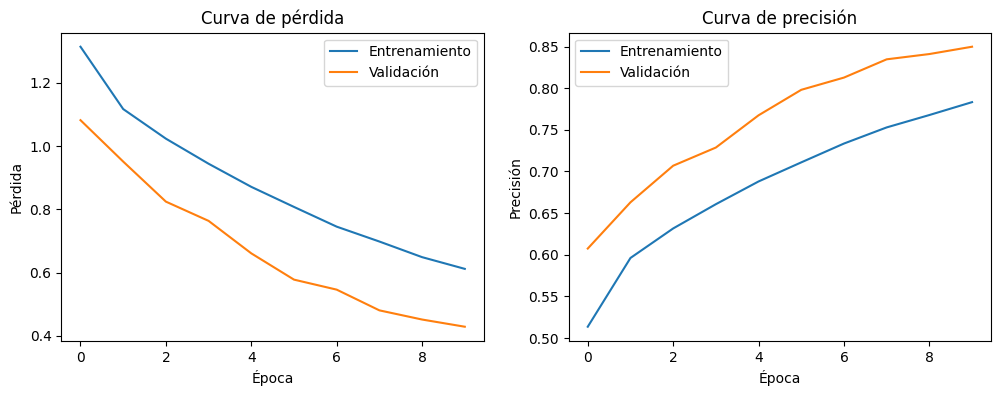

In [188]:
import matplotlib.pyplot as plt


train_loss = historymodel7_2.history['loss']
val_loss = historymodel7_2.history['val_loss']
train_accuracy = historymodel7_2.history['sparse_categorical_accuracy']
val_accuracy = historymodel7_2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [189]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True))(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(50, 2,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(50, 3,activation="relu")(bert_output)
#x_3 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(50, 4,activation="relu")(bert_output)
#x_4 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_4,x_4)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.4)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7_3 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7_3.layers[2].trainable=False
# Compila el modelo
model7_3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7_3.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_19[0][0]',               
                                thPoolingAndCrossAt               'input_20[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [190]:
historymodel7_3 = model7_3.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 715s 3s/step - loss: 1.3799 - sparse_categorical_accuracy: 0.4884 - val_loss: 1.1080 - val_sparse_categorical_accuracy: 0.5918
Epoch 2/10
246/246 [==============================] - 603s 2s/step - loss: 1.1395 - sparse_categorical_accuracy: 0.5852 - val_loss: 0.9967 - val_sparse_categorical_accuracy: 0.6378
Epoch 3/10
246/246 [==============================] - 602s 2s/step - loss: 1.0548 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.8840 - val_sparse_categorical_accuracy: 0.6887
Epoch 4/10
246/246 [==============================] - 603s 2s/step - loss: 0.9825 - sparse_categorical_accuracy: 0.6453 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7108
Epoch 5/10
246/246 [==============================] - 603s 2s/step - loss: 0.9224 - sparse_categorical_accuracy: 0.6696 - val_loss: 0.7607 - val_sparse_categorical_accuracy: 0.7378
Epoch 6/10
246/246 [==============================] - 603s 2s/step - loss: 0.8587 - sparse_cate

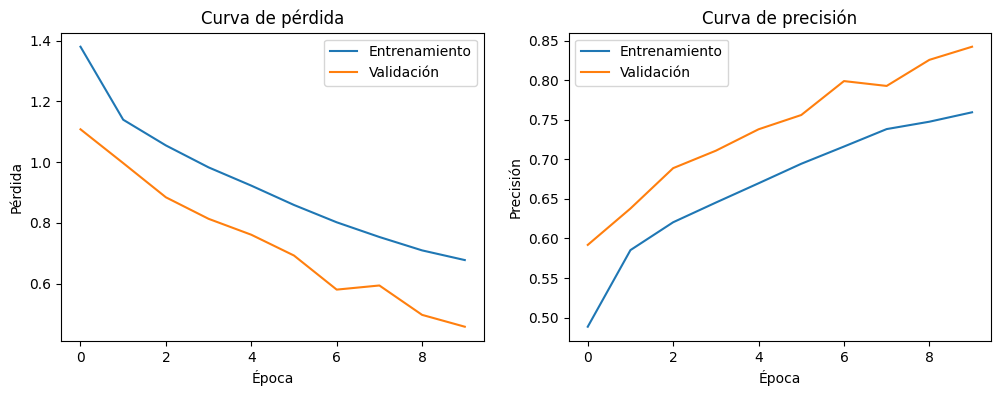

In [191]:
import matplotlib.pyplot as plt


train_loss = historymodel7_3.history['loss']
val_loss = historymodel7_3.history['val_loss']
train_accuracy = historymodel7_3.history['sparse_categorical_accuracy']
val_accuracy = historymodel7_3.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [201]:
result_3 = model7_3.evaluate(test_dataset_tensor)
print(result_3)

36/36 [==============================] - 60s 2s/step - loss: 0.4509 - sparse_categorical_accuracy: 0.8438
[0.4508795142173767, 0.8437569737434387]


In [192]:

input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_1 = tf.keras.layers.Conv1D(64, 2,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64, 3,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64, 4,activation="relu")(bert_output)
#x_3 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64, 5,activation="relu")(bert_output)
#x_4 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_4,x_4)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.3)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7_4 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7_4.layers[2].trainable=False
# Compila el modelo
model7_4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7_4.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_21[0][0]',               
                                thPoolingAndCrossAt               'input_22[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                         

In [193]:
historymodel7_4 = model7_4.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 689s 2s/step - loss: 1.3519 - sparse_categorical_accuracy: 0.5023 - val_loss: 1.1354 - val_sparse_categorical_accuracy: 0.5815
Epoch 2/10
246/246 [==============================] - 584s 2s/step - loss: 1.1297 - sparse_categorical_accuracy: 0.5852 - val_loss: 0.9957 - val_sparse_categorical_accuracy: 0.6362
Epoch 3/10
246/246 [==============================] - 584s 2s/step - loss: 1.0408 - sparse_categorical_accuracy: 0.6240 - val_loss: 0.8593 - val_sparse_categorical_accuracy: 0.6902
Epoch 4/10
246/246 [==============================] - 585s 2s/step - loss: 0.9591 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.7612 - val_sparse_categorical_accuracy: 0.7276
Epoch 5/10
246/246 [==============================] - 584s 2s/step - loss: 0.8862 - sparse_categorical_accuracy: 0.6823 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.7514
Epoch 6/10
246/246 [==============================] - 585s 2s/step - loss: 0.8225 - sparse_cate

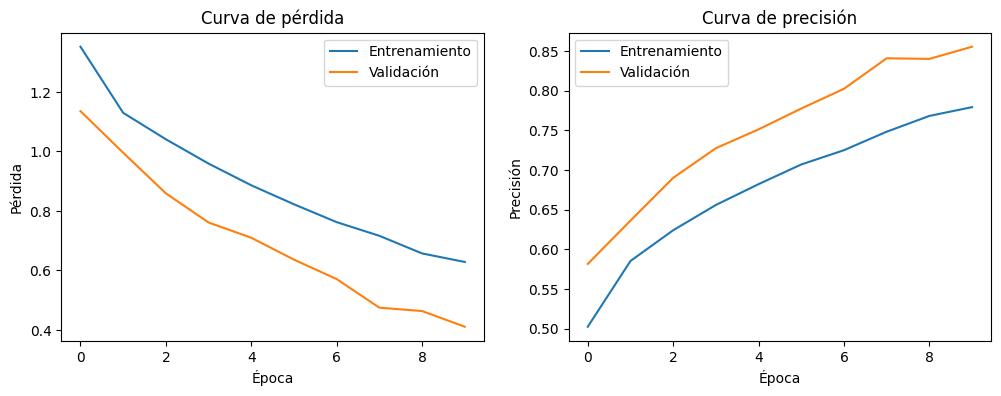

In [194]:
import matplotlib.pyplot as plt


train_loss = historymodel7_4.history['loss']
val_loss = historymodel7_4.history['val_loss']
train_accuracy = historymodel7_4.history['sparse_categorical_accuracy']
val_accuracy = historymodel7_4.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [202]:
result_4 = model7_4.evaluate(test_dataset_tensor)
print(result_4)

36/36 [==============================] - 58s 2s/step - loss: 0.4025 - sparse_categorical_accuracy: 0.8622
[0.40254610776901245, 0.862230122089386]


In [195]:
input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_1 = tf.keras.layers.Conv1D(64, 2,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64, 3,activation="relu")(bert_output)
#x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64, 4,activation="relu")(bert_output)
#x_3 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64, 5,activation="relu")(bert_output)
#x_4 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_4,x_4)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.3)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7_5 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7_5.layers[2].trainable=False
# Compila el modelo
model7_5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_23[0][0]',               
                                thPoolingAndCrossAt               'input_24[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [196]:
historymodel7_5 = model7_5.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 658s 2s/step - loss: 1.3375 - sparse_categorical_accuracy: 0.5063 - val_loss: 1.0771 - val_sparse_categorical_accuracy: 0.6133
Epoch 2/10
246/246 [==============================] - 571s 2s/step - loss: 1.1190 - sparse_categorical_accuracy: 0.5949 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.6592
Epoch 3/10
246/246 [==============================] - 571s 2s/step - loss: 1.0301 - sparse_categorical_accuracy: 0.6273 - val_loss: 0.8422 - val_sparse_categorical_accuracy: 0.6964
Epoch 4/10
246/246 [==============================] - 571s 2s/step - loss: 0.9511 - sparse_categorical_accuracy: 0.6593 - val_loss: 0.7383 - val_sparse_categorical_accuracy: 0.7401
Epoch 5/10
246/246 [==============================] - 571s 2s/step - loss: 0.8705 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.7700
Epoch 6/10
246/246 [==============================] - 571s 2s/step - loss: 0.7958 - sparse_cate

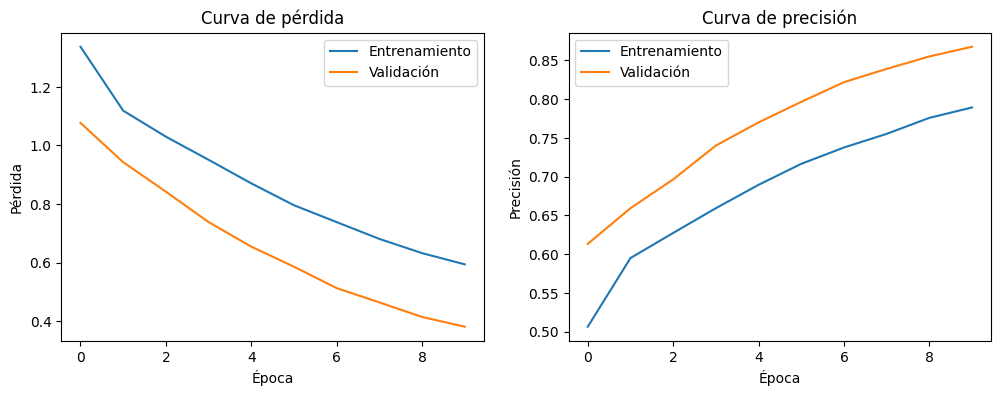

In [199]:
import matplotlib.pyplot as plt


train_loss = historymodel7_5.history['loss']
val_loss = historymodel7_5.history['val_loss']
train_accuracy = historymodel7_5.history['sparse_categorical_accuracy']
val_accuracy = historymodel7_5.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [203]:
result_5 = model7_5.evaluate(test_dataset_tensor)
print(result_5)

36/36 [==============================] - 59s 2s/step - loss: 0.3856 - sparse_categorical_accuracy: 0.8576
[0.3855704665184021, 0.8575562238693237]


In [197]:

input_ids_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
attention_mask_layer = tf.keras.layers.Input(shape=(300,),dtype=tf.int32)
bert_output = bert_model(input_ids=input_ids_layer, attention_mask=attention_mask_layer)[0]

x_1 = tf.keras.layers.Conv1D(64, 2,activation="relu")(bert_output)
x_1 = tf.keras.layers.GlobalMaxPooling1D()(x_1)
x_2 = tf.keras.layers.Conv1D(64, 3,activation="relu")(bert_output)
x_2 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_2,x_2)
x_2 = tf.keras.layers.GlobalMaxPooling1D()(x_2)
x_3 = tf.keras.layers.Conv1D(64, 4,activation="relu")(bert_output)
x_3 = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=128)(x_3,x_3)
x_3 = tf.keras.layers.GlobalMaxPooling1D()(x_3)
x_4 = tf.keras.layers.Conv1D(64, 5,activation="relu")(bert_output)
x_4 = tf.keras.layers.GlobalMaxPooling1D()(x_4)


merged = tf.concat([x_1,x_2,x_3,x_4], axis=-1)
dense_layer = tf.keras.layers.Dense(256, activation="relu")(merged)
dropout = tf.keras.layers.Dropout(0.3)(dense_layer)
dense_output = tf.keras.layers.Dense(7, activation='softmax')(dropout)
model7_6 = tf.keras.models.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=dense_output)

model7_6.layers[2].trainable=False
# Compila el modelo
model7_6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model7_6.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_25[0][0]',               
                                thPoolingAndCrossAt               'input_26[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                        

In [198]:
historymodel7_6 = model7_6.fit(
    train_dataset_tensor,
    validation_data=val_dataset_tensor,
    epochs=10,
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
246/246 [==============================] - 672s 2s/step - loss: 1.3093 - sparse_categorical_accuracy: 0.5143 - val_loss: 1.0894 - val_sparse_categorical_accuracy: 0.6035
Epoch 2/10
246/246 [==============================] - 581s 2s/step - loss: 1.1194 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.9838 - val_sparse_categorical_accuracy: 0.6403
Epoch 3/10
246/246 [==============================] - 580s 2s/step - loss: 1.0281 - sparse_categorical_accuracy: 0.6288 - val_loss: 0.8852 - val_sparse_categorical_accuracy: 0.6815
Epoch 4/10
246/246 [==============================] - 580s 2s/step - loss: 0.9483 - sparse_categorical_accuracy: 0.6604 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.7334
Epoch 5/10
246/246 [==============================] - 580s 2s/step - loss: 0.8707 - sparse_categorical_accuracy: 0.6858 - val_loss: 0.7015 - val_sparse_categorical_accuracy: 0.7485
Epoch 6/10
246/246 [==============================] - 580s 2s/step - loss: 0.8099 - sparse_cate

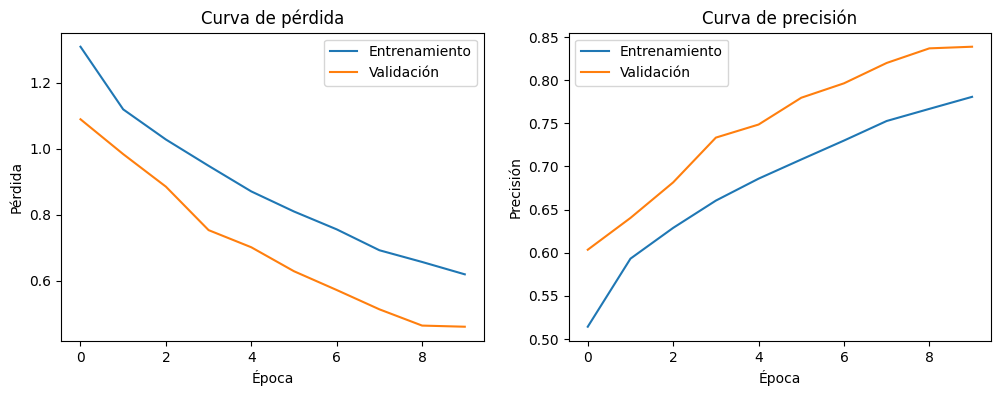

In [200]:
import matplotlib.pyplot as plt


train_loss = historymodel7_6.history['loss']
val_loss = historymodel7_6.history['val_loss']
train_accuracy = historymodel7_6.history['sparse_categorical_accuracy']
val_accuracy = historymodel7_6.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [204]:
result_6 = model7_6.evaluate(test_dataset_tensor)
print(result_6)

36/36 [==============================] - 59s 2s/step - loss: 0.4364 - sparse_categorical_accuracy: 0.8377
[0.4364335536956787, 0.8377476334571838]


## BERT

### Tokenizer definition

In [30]:
FullTokenizer = bert.bert_tokenization.FullTokenizer #llamada a la instancia de bert libreria para obtener la tokenización.



#Llamado al modelo pre-entrenado de Bert L-12
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1", trainable=False)


#obtener el vocabulario del Hub de bert
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#transformación a minusculas
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#aplicación al tokenizador mediante el vocabulario y transformando las palabras a minusculas
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### Data transformation for bert

In [31]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [32]:
#Llamada a la función que convierte en tokens
data_inputs = [encode_sentence(sentence) for sentence in texto_clean]

In [33]:
import random

#Se crea una lista mediante la secuencia, su respectivo label y el largo de la frase.
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]


random.shuffle(data_with_len) #Se mezcla los datos de forma aleatoria

valor_maximo=-np.inf

for sent_lab in data_with_len:
    if sent_lab[2]>valor_maximo:
        valor_maximo=sent_lab[2]

#Se genera una tupla, se entrega la secuencia para obtener las ids, mask y segments, Además se agrega el label de la secuencia.
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
               for sent_lab in data_with_len]

In [34]:
valor_maximo

200

In [35]:
sorted_all[0:10]

[([[101, 21534, 4105, 1663, 178, 112, 1325, 1267, 1128, 1224, 119, 102],
   array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  4),
 ([[101,
    178,
    1631,
    6782,
    1165,
    1139,
    7059,
    3628,
    1129,
    1444,
    1121,
    2669,
    1278,
    1285,
    1496,
    1106,
    1117,
    4290,
    1107,
    170,
    1295,
    1104,
    2548,
    1105,
    1178,
    1202,
    183,
    112,
    189,
    1221,
    1184,
    12861,
    1295,
    2541,
    1106,
    1294,
    119,
    102],
   array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   [0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0]],
  5),
 ([[101,
    1612,
    136,
    1150,
    1474,

In [36]:
sorted_all[24]

([[101, 1184, 136, 106, 12861, 1295, 106, 102],
  array([1, 1, 1, 1, 1, 1, 1, 1]),
  [0, 0, 0, 0, 0, 0, 0, 0]],
 6)

In [37]:
len(sorted_all)

44919

### Dataset creation

In [38]:
# Creación del generador, mediante la entrega de la tupla de los datos.
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32)) #La salida es entera de tuplas de los datos transformados int(texto), int(etiqueta)

### Application of padding and batches

In [39]:
BATCH_SIZE = 64
SEQUENCE_LENGTH=300
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, SEQUENCE_LENGTH), ()),
                                       padding_values=(0, 0))

In [175]:
for i, element in enumerate(all_batched.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1517,  1165, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165, 12861, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1105,  1304, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101, 14863,  1122, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1152,  5080, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   178,  8264, ...,     0,     0,     0],


In [176]:
first_batch = next(iter(all_batched.take(1)))

primer_valor_primer_batch = first_batch[0][0]  # Acceder al primer elemento del primer lote
print(primer_valor_primer_batch)

tf.Tensor(
[[  101  1517  1165   178  1129  2647  2041  1120  2286  1843   178  3333
   1106 14131  1139  2555  1113   170 13670  1112  1869  2815  1464  5307
    178  1341  1115  1122  1129   170   177 19429  1611  1105   178 22591
   1566  3737   119   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  

### Splitting of train, validation and testing datasets

In [40]:
import math

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))

# Se crea los conjuntos de datos para entrenamiento, validación y prueba
val_dataset = all_batched.take(NB_BATCHES_VAL)
test_dataset = all_batched.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_VAL + NB_BATCHES_TEST) 

BUFFER_SIZE = 10000
train_dataset = train_dataset.shuffle(BUFFER_SIZE)


NB_BATCHES totales:  702
NB_BATCHES validacion:  140
NB_BATCHES testeo:  70
NB_BATCHES entrenamiento 492


In [178]:
print("Train size: ", len(list(train_dataset)))
print("Validation size: ", len(list(val_dataset)))
print("Test size: ", len(list(test_dataset)))

Train size:  492
Validation size:  140
Test size:  70


In [183]:
for i, element in enumerate(train_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101, 23998,  1362, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   170,  6124, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1218,   178, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101,   177,  1306, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1120,   170, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165,  1141, ...,     0,     0,     0],


In [180]:
for i, element in enumerate(val_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1517,  1165, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165, 12861, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1105,  1304, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101, 14863,  1122, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1152,  5080, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   178,  8264, ...,     0,     0,     0],


In [181]:
for i, element in enumerate(test_dataset.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(64, 3, 300), dtype=int32, numpy=
array([[[  101,  1165, 20839, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,   177,  6262, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1165,  1175, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101,  1885,  1869, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  1517,   170, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2100,  1234, ...,     0,     0,     0],


### Definición de datos de testeo

#### MELD

In [30]:
meld_text = pd.read_csv('test_sent_emo.csv')
meld_text = meld_text.iloc[:,[1,3]]
meld_text = meld_text.rename(columns={'Utterance':'texto'})
meld_text['Emotion'] = meld_text['Emotion'].replace(['anger', 'joy', 'sadness'], ['angry', 'happy', 'sad'])
meld_text

,texto,Emotion
0,Why do all youre coffee mugs have numbers on ...,surprise
1,Oh. Thats so Monica can keep track. That way ...,angry
2,Y'know what?,neutral
3,"Come on, Lydia, you can do it.",neutral
4,Push!,happy
...,...,...
2605,"Yeah, I mean, come on Ross, no one will even n...",neutral
2606,They’re not listening too me?,surprise
2607,Of course they’re listening to you! Everybody ...,neutral
2608,Monica you really think I should try this phas...,neutral


In [31]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
meld_text['texto'] = meld_text['texto'].apply(eliminarAcentos)
meld_text

,texto,Emotion
0,Why do all you're coffee mugs have numbers on ...,surprise
1,Oh. That's so Monica can keep track. That way ...,angry
2,Y'know what?,neutral
3,"Come on, Lydia, you can do it.",neutral
4,Push!,happy
...,...,...
2605,"Yeah, I mean, come on Ross, no one will even n...",neutral
2606,They’re not listening too me?,surprise
2607,Of course they’re listening to you! Everybody ...,neutral
2608,Monica you really think I should try this phas...,neutral


In [32]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [33]:

lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean_text = [clean_emotion_text(text) for text in tqdm(meld_text['texto'])]

100%|██████████| 2610/2610 [00:05<00:00, 480.10it/s]


In [34]:
le_text2 = LabelEncoder()

data_labels_text = le_text2.fit_transform(meld_text['Emotion'])
data_labels_text

array([6, 0, 4, ..., 4, 4, 4])

In [35]:
le_text2.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [ ]:
data_inputs_text = [encode_sentence(sent) for sent in texto_clean_text]

In [ ]:
sent_label = [[sent_text, data_labels_text[i]] 
              for i, sent_text in enumerate(data_inputs_text)]

sorted_all_text = [([get_ids(sent_lab_text[0]),
                    get_mask(sent_lab_text[0]),
                    get_segments(sent_lab_text[0])],
                    sent_lab_text[1]) for sent_lab_text in sent_label]

In [ ]:
dataset_text = tf.data.Dataset.from_generator(lambda: sorted_all_text, output_types=(tf.int32, tf.int32))

In [ ]:
dataset_text_batch = dataset_text.padded_batch(BATCH_SIZE,
                                               padded_shapes=((3,SEQUENCE_LENGTH), ()),
                                               padding_values=(0,0))

#### IEMOCAP

In [36]:
iemocap_text = pd.read_csv('df_filters.csv')
iemocap_text

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [37]:
def eliminarAcentos(texto):
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")
    return texto
iemocap_text['Texto'] = iemocap_text['Texto'].apply(eliminarAcentos)
iemocap_text

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
...,...,...
4632,oh! Marry you again? I wouldn't marry you agai...,angry
4633,Beast,angry
4634,You're a wicked little vampire. And I pray to ...,angry
4635,Brute,angry


In [ ]:
iemocap_text[250:290]

,Texto,Emoción
250,How do you know he's even thinking about it?,neutral
251,It's got that about it.,angry
252,"What is going on here, Joe?",angry
253,She is not his girl. She knows she's not.,angry
254,Then why is she still single? New York is full...,angry
255,How do you know why she waited?,neutral
256,"Because she knows what I know, that's why. She...",angry
257,Nobody in this house dares take away her faith...,angry
258,I want you to-- I want you to act like he is c...,angry
259,I won't stand for any nonsense.,angry


In [ ]:
iemocap_text[0:10]

,Texto,Emoción
0,Excuse me.,neutral
1,Yeah.,neutral
2,Is there a problem?,neutral
3,Well what's the problem? Let me change it.,neutral
4,That's out of control.,angry
5,I don't understand why this is so complicated ...,angry
6,"Clearly. You know, do you have like a supervis...",neutral
7,Yeah. Do you want to see my supervisor? Huh? Y...,angry
8,Did you get the mail? So you saw my letter?,sad
9,Yeah. I know.,sad


In [38]:
# Descargar el paquete 'averaged_perceptron_tagger' para la lematización pre-entrenada
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [39]:
lemmatizer = WordNetLemmatizer()

# Definir la función para asignar etiquetas POS de WordNet a etiquetas POS de NLTK
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def clean_emotion_text(texto):
    if isinstance(texto, list): #En caso de ser lista toma el primer valor
        texto = texto[0] 

    if texto.startswith('[') and texto.endswith(']'): #Si empieza y termina con [ ] los elimina
        texto = texto[1:-1]

    texto = texto.lower()

    texto = texto.replace('á', '')
    texto = texto.replace('\n', '')
    texto = texto.replace('[]', "'")
    texto = texto.replace('', "'")

    texto = re.sub(r"@[A-Za-z0-9]+", ' ', texto)
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
    texto = re.sub(r"[^a-zA-Z.'!?]", ' ', texto)
    texto = re.sub(r"#", ' ', texto)
    texto = re.sub(r"\s(?=\')", "", texto) #Eliminar los espacios que une los apóstrofes
    texto = texto.replace("' ", "'")
    texto = re.sub(r" +", ' ', texto)

    # Tokenizar el texto y obtener las etiquetas POS
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(texto))
    
    # Mapear las etiquetas POS de NLTK a etiquetas POS de WordNet
    wordnet_tagged = [(word, pos_tagger(tag)) for word, tag in pos_tagged]
    
    # Lematizar cada palabra con su etiqueta POS correspondiente
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    
    # Unir las palabras lematizadas para formar el texto lematizado
    lemmatized_text = " ".join(lemmatized_words)

    lemmatized_text = re.sub(r"\s(?=\')", "", lemmatized_text) #Eliminar los espacios que une los apóstrofes
    lemmatized_text = re.sub(r"\s(?=\.)", "", lemmatized_text) #Eliminar los espacios que une los .
    lemmatized_text = re.sub(r"\s(?=\!)", "", lemmatized_text) #Eliminar los espacios que une los !
    lemmatized_text = re.sub(r"\s(?=\?)", "", lemmatized_text) #Eliminar los espacios que une los ?
    
    return lemmatized_text

# Llamado a la función de limpieza
texto_clean_text_iemocap = [clean_emotion_text(text) for text in tqdm(iemocap_text['Texto'])]

100%|██████████| 4637/4637 [00:10<00:00, 439.48it/s]


In [ ]:
texto_clean_text_iemocap[0:10]

['excuse me.',
 'yeah.',
 'be there a problem?',
 "well what's the problem? let me change it.",
 "that's out of control.",
 "i do n't understand why this be so complicate for people when they get here. it's just a simple form. i just need an id.",
 'clearly. you know do you have like a supervisor or something?',
 "yeah. do you want to see my supervisor? huh? yeah. do you want to see my supervisor? fine. i'll be right back.",
 'do you get the mail? so you saw my letter?',
 'yeah. i know.']

In [40]:
le_text3 = LabelEncoder()

data_labels_text_iemocap = le_text3.fit_transform(iemocap_text['Emoción'])
data_labels_text_iemocap

array([4, 4, 4, ..., 0, 0, 0])

In [41]:
le_text3.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
#Función para aplicar el token en cada sentencia
def encode_sentence(sent):
  return ["[CLS]"] + tokenizer.tokenize(sent) + ["[SEP]"]
  #Se aplica CLS para el inicio de clasificación y SEP para la separación en cada secuencia. Esto lo pide Bert.

#Transforma los tokens en lista de ids para obtener la forma numerica de los datos
def get_ids(tokens):
  return tokenizer.convert_tokens_to_ids(tokens)

#Se aplica la mascara para eliminar los tokens de PAD que son los padding para igualar los valores, igualando el token PAD en 0
def get_mask(tokens):
  return np.char.not_equal(tokens, "[PAD]").astype(int)

#Indica si el token es de la primera frase o segunda fase, agrando 0 o 1 dependiendo de la separación
def get_segments(tokens):
  seg_ids = [] #es una lista que se rellena con el token
  current_seg_ids = 0

  for tok in tokens: #recorre todos los tokens
    seg_ids.append(current_seg_ids)
    if tok == "[SEP]": #si el token es de separación
      current_seg_ids = 1-current_seg_ids #convierte los 1 en 0 y viceversa

  return seg_ids

In [ ]:
data_inputs_text_iemocap = [encode_sentence(sent) for sent in texto_clean_text_iemocap]

In [ ]:
data_inputs_text_iemocap[0:3]

[['[CLS]', 'excuse', 'me', '.', '[SEP]'],
 ['[CLS]', 'yeah', '.', '[SEP]'],
 ['[CLS]', 'be', 'there', 'a', 'problem', '?', '[SEP]']]

In [ ]:
sent_label_iemocap = [[sent_text, data_labels_text_iemocap[i]] 
              for i, sent_text in enumerate(data_inputs_text_iemocap)]

sorted_all_text_iemocap = [([get_ids(sent_lab_text[0]),
                    get_mask(sent_lab_text[0]),
                    get_segments(sent_lab_text[0])],
                    sent_lab_text[1]) for sent_lab_text in sent_label_iemocap]

In [ ]:
sorted_all_text_iemocap[0:3]

[([[101, 9107, 1143, 119, 102], array([1, 1, 1, 1, 1]), [0, 0, 0, 0, 0]], 4),
 ([[101, 8147, 119, 102], array([1, 1, 1, 1]), [0, 0, 0, 0]], 4),
 ([[101, 1129, 1175, 170, 2463, 136, 102],
   array([1, 1, 1, 1, 1, 1, 1]),
   [0, 0, 0, 0, 0, 0, 0]],
  4)]

In [ ]:
dataset_text_iemocap = tf.data.Dataset.from_generator(lambda: sorted_all_text_iemocap, output_types=(tf.int32, tf.int32))

In [ ]:
dataset_text_batch_iemocap = dataset_text_iemocap.padded_batch(BATCH_SIZE,
                                               padded_shapes=((3,SEQUENCE_LENGTH), ()),
                                               padding_values=(0,0))

### Model Bert + NGram-CNN

In [189]:
from keras import layers
from keras import Model

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(sequence_output)
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(sequence_output)
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(sequence_output)
x_3 = layers.GlobalMaxPooling1D()(x_3)
#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

#merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
merged = tf.concat([x_1, x_2, x_3], axis=-1)
dropout = layers.Dropout(0.2)(merged)
last_dense = layers.Dense(units=256, activation="relu")(dropout)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertCnn = Model(inputs=inputs_full, outputs=output)

modelBertCnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_24 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_25 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_26 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

In [190]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERT/CNN/64batch', exist_ok=True)


checkpoint_path = 'model/BERT/CNN/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/CNN/64batch', exist_ok=True)



log_dir = "logs/BERT/CNN/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [193]:
historymodelBertCnn =  modelBertCnn.fit(
    train_dataset,
    epochs=15,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/15
    492/Unknown - 577s 898ms/step - loss: 1.4235 - sparse_categorical_accuracy: 0.4664
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.58739, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_01_val_0.5874\assets


492/492 [==============================] - 848s 1s/step - loss: 1.4235 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.1503 - val_sparse_categorical_accuracy: 0.5874
Epoch 2/15
492/492 [==============================] - ETA: 0s - loss: 1.1585 - sparse_categorical_accuracy: 0.5809
Epoch 2: val_sparse_categorical_accuracy improved from 0.58739 to 0.61373, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_02_val_0.6137\assets


492/492 [==============================] - 708s 1s/step - loss: 1.1585 - sparse_categorical_accuracy: 0.5809 - val_loss: 1.0742 - val_sparse_categorical_accuracy: 0.6137
Epoch 3/15
492/492 [==============================] - ETA: 0s - loss: 1.0329 - sparse_categorical_accuracy: 0.6313
Epoch 3: val_sparse_categorical_accuracy improved from 0.61373 to 0.64654, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_03_val_0.6465\assets


492/492 [==============================] - 755s 1s/step - loss: 1.0329 - sparse_categorical_accuracy: 0.6313 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.6465
Epoch 4/15
492/492 [==============================] - ETA: 0s - loss: 0.9295 - sparse_categorical_accuracy: 0.6724
Epoch 4: val_sparse_categorical_accuracy improved from 0.64654 to 0.66384, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_04_val_0.6638\assets


492/492 [==============================] - 709s 1s/step - loss: 0.9295 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.9507 - val_sparse_categorical_accuracy: 0.6638
Epoch 5/15
492/492 [==============================] - ETA: 0s - loss: 0.8356 - sparse_categorical_accuracy: 0.7028
Epoch 5: val_sparse_categorical_accuracy improved from 0.66384 to 0.67288, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_05_val_0.6729\assets


492/492 [==============================] - 708s 1s/step - loss: 0.8356 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.9310 - val_sparse_categorical_accuracy: 0.6729
Epoch 6/15
492/492 [==============================] - ETA: 0s - loss: 0.7510 - sparse_categorical_accuracy: 0.7368
Epoch 6: val_sparse_categorical_accuracy improved from 0.67288 to 0.68203, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_06_val_0.6820\assets


492/492 [==============================] - 750s 1s/step - loss: 0.7510 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9137 - val_sparse_categorical_accuracy: 0.6820
Epoch 7/15
492/492 [==============================] - ETA: 0s - loss: 0.6781 - sparse_categorical_accuracy: 0.7614
Epoch 7: val_sparse_categorical_accuracy improved from 0.68203 to 0.69375, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_07_val_0.6938\assets


492/492 [==============================] - 709s 1s/step - loss: 0.6781 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.9209 - val_sparse_categorical_accuracy: 0.6938
Epoch 8/15
492/492 [==============================] - ETA: 0s - loss: 0.6173 - sparse_categorical_accuracy: 0.7837
Epoch 8: val_sparse_categorical_accuracy improved from 0.69375 to 0.69855, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_08_val_0.6985\assets


492/492 [==============================] - 708s 1s/step - loss: 0.6173 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.8929 - val_sparse_categorical_accuracy: 0.6985
Epoch 9/15
492/492 [==============================] - ETA: 0s - loss: 0.5711 - sparse_categorical_accuracy: 0.7997
Epoch 9: val_sparse_categorical_accuracy improved from 0.69855 to 0.70167, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_09_val_0.7017\assets


492/492 [==============================] - 710s 1s/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7997 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.7017
Epoch 10/15
492/492 [==============================] - ETA: 0s - loss: 0.5226 - sparse_categorical_accuracy: 0.8157
Epoch 10: val_sparse_categorical_accuracy improved from 0.70167 to 0.70670, saving model to model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_10_val_0.7067\assets


492/492 [==============================] - 765s 1s/step - loss: 0.5226 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.8998 - val_sparse_categorical_accuracy: 0.7067
Epoch 11/15
492/492 [==============================] - ETA: 0s - loss: 0.4767 - sparse_categorical_accuracy: 0.8323
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.70670
492/492 [==============================] - 619s 1s/step - loss: 0.4767 - sparse_categorical_accuracy: 0.8323 - val_loss: 0.9640 - val_sparse_categorical_accuracy: 0.6939
Epoch 12/15
492/492 [==============================] - ETA: 0s - loss: 0.4548 - sparse_categorical_accuracy: 0.8430
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.70670
492/492 [==============================] - 619s 1s/step - loss: 0.4548 - sparse_categorical_accuracy: 0.8430 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.7021
Epoch 13/15
492/492 [==============================] - ETA: 0s - loss: 0.4238 - sparse_categorical_accuracy: 0.8520


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_15_val_0.7087\assets


INFO:tensorflow:Assets written to: model/BERT/CNN/64batch\BERT_CNN_model_best_15_val_0.7087\assets


492/492 [==============================] - 706s 1s/step - loss: 0.3735 - sparse_categorical_accuracy: 0.8692 - val_loss: 1.0021 - val_sparse_categorical_accuracy: 0.7087


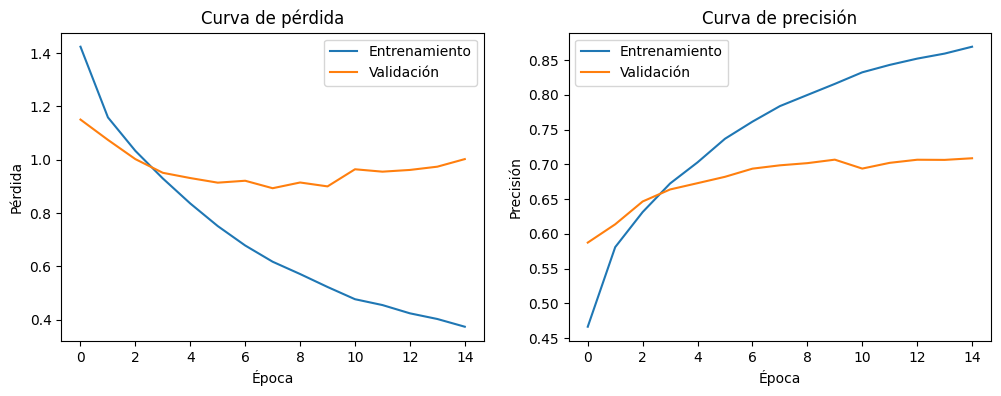

In [194]:
import matplotlib.pyplot as plt


train_loss = historymodelBertCnn.history['loss']
val_loss = historymodelBertCnn.history['val_loss']
train_accuracy = historymodelBertCnn.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertCnn.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [195]:
modelBertCnn.evaluate(test_dataset)

70/70 [==============================] - 71s 914ms/step - loss: 0.9849 - sparse_categorical_accuracy: 0.7098


[0.9848834276199341, 0.7098214030265808]

In [42]:
from keras import layers
from keras import Model

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

x_1 = layers.Conv1D(filters=32, kernel_size=(3), activation="relu", padding="same")(sequence_output)
x_1 = layers.GlobalMaxPooling1D()(x_1)

#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

#merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
dropout = layers.Dropout(0.5)(x_1)
#last_dense = layers.Dense(units=256, activation="relu")(dropout)
#dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertCnn = Model(inputs=inputs_full, outputs=output)

modelBertCnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_3 (Lambda)              (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_4 (Lambda)              (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_5 (Lambda)              (None, 300)          0           ['inputs[0][0]']                 
                                                                                              

In [43]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERT/CNN2/64batch', exist_ok=True)


checkpoint_path = 'model/BERT/CNN2/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/CNN2/64batch', exist_ok=True)



log_dir = "logs/BERT/CNN2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [44]:
historymodelBertCnn =  modelBertCnn.fit(
    train_dataset,
    epochs=15,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/15
    492/Unknown - 591s 884ms/step - loss: 1.5692 - sparse_categorical_accuracy: 0.4079
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.53181, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_01_val_0.5318


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_01_val_0.5318\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_01_val_0.5318\assets


492/492 [==============================] - 850s 1s/step - loss: 1.5692 - sparse_categorical_accuracy: 0.4079 - val_loss: 1.2922 - val_sparse_categorical_accuracy: 0.5318
Epoch 2/15
492/492 [==============================] - ETA: 0s - loss: 1.3566 - sparse_categorical_accuracy: 0.4995
Epoch 2: val_sparse_categorical_accuracy improved from 0.53181 to 0.57589, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_02_val_0.5759


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_02_val_0.5759\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_02_val_0.5759\assets


492/492 [==============================] - 669s 1s/step - loss: 1.3566 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.5759
Epoch 3/15
492/492 [==============================] - ETA: 0s - loss: 1.2831 - sparse_categorical_accuracy: 0.5296
Epoch 3: val_sparse_categorical_accuracy improved from 0.57589 to 0.58025, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_03_val_0.5802


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_03_val_0.5802\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_03_val_0.5802\assets


492/492 [==============================] - 699s 1s/step - loss: 1.2831 - sparse_categorical_accuracy: 0.5296 - val_loss: 1.1711 - val_sparse_categorical_accuracy: 0.5802
Epoch 4/15
492/492 [==============================] - ETA: 0s - loss: 1.2470 - sparse_categorical_accuracy: 0.5464
Epoch 4: val_sparse_categorical_accuracy improved from 0.58025 to 0.59330, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_04_val_0.5933


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_04_val_0.5933\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_04_val_0.5933\assets


492/492 [==============================] - 671s 1s/step - loss: 1.2470 - sparse_categorical_accuracy: 0.5464 - val_loss: 1.1470 - val_sparse_categorical_accuracy: 0.5933
Epoch 5/15
492/492 [==============================] - ETA: 0s - loss: 1.2048 - sparse_categorical_accuracy: 0.5616
Epoch 5: val_sparse_categorical_accuracy improved from 0.59330 to 0.59922, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_05_val_0.5992


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_05_val_0.5992\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_05_val_0.5992\assets


492/492 [==============================] - 697s 1s/step - loss: 1.2048 - sparse_categorical_accuracy: 0.5616 - val_loss: 1.1084 - val_sparse_categorical_accuracy: 0.5992
Epoch 6/15
492/492 [==============================] - ETA: 0s - loss: 1.1647 - sparse_categorical_accuracy: 0.5762
Epoch 6: val_sparse_categorical_accuracy improved from 0.59922 to 0.61462, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_06_val_0.6146


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_06_val_0.6146\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_06_val_0.6146\assets


492/492 [==============================] - 671s 1s/step - loss: 1.1647 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.0801 - val_sparse_categorical_accuracy: 0.6146
Epoch 7/15
492/492 [==============================] - ETA: 0s - loss: 1.1380 - sparse_categorical_accuracy: 0.5824
Epoch 7: val_sparse_categorical_accuracy improved from 0.61462 to 0.61763, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_07_val_0.6176


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_07_val_0.6176\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_07_val_0.6176\assets


492/492 [==============================] - 672s 1s/step - loss: 1.1380 - sparse_categorical_accuracy: 0.5824 - val_loss: 1.0730 - val_sparse_categorical_accuracy: 0.6176
Epoch 8/15
492/492 [==============================] - ETA: 0s - loss: 1.1055 - sparse_categorical_accuracy: 0.5945
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.61763
492/492 [==============================] - 584s 1s/step - loss: 1.1055 - sparse_categorical_accuracy: 0.5945 - val_loss: 1.0556 - val_sparse_categorical_accuracy: 0.6147
Epoch 9/15
492/492 [==============================] - ETA: 0s - loss: 1.0901 - sparse_categorical_accuracy: 0.6007
Epoch 9: val_sparse_categorical_accuracy improved from 0.61763 to 0.62511, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_09_val_0.6251


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_09_val_0.6251\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_09_val_0.6251\assets


492/492 [==============================] - 713s 1s/step - loss: 1.0901 - sparse_categorical_accuracy: 0.6007 - val_loss: 1.0510 - val_sparse_categorical_accuracy: 0.6251
Epoch 10/15
492/492 [==============================] - ETA: 0s - loss: 1.0663 - sparse_categorical_accuracy: 0.6087
Epoch 10: val_sparse_categorical_accuracy improved from 0.62511 to 0.62946, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_10_val_0.6295


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_10_val_0.6295\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_10_val_0.6295\assets


492/492 [==============================] - 674s 1s/step - loss: 1.0663 - sparse_categorical_accuracy: 0.6087 - val_loss: 1.0455 - val_sparse_categorical_accuracy: 0.6295
Epoch 11/15
492/492 [==============================] - ETA: 0s - loss: 1.0497 - sparse_categorical_accuracy: 0.6156
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.62946
492/492 [==============================] - 603s 1s/step - loss: 1.0497 - sparse_categorical_accuracy: 0.6156 - val_loss: 1.0416 - val_sparse_categorical_accuracy: 0.6246
Epoch 12/15
492/492 [==============================] - ETA: 0s - loss: 1.0334 - sparse_categorical_accuracy: 0.6201
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.62946
492/492 [==============================] - 601s 1s/step - loss: 1.0334 - sparse_categorical_accuracy: 0.6201 - val_loss: 1.0369 - val_sparse_categorical_accuracy: 0.6281
Epoch 13/15
492/492 [==============================] - ETA: 0s - loss: 1.0092 - sparse_categorical_accuracy: 0.6270


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_14_val_0.6336\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_14_val_0.6336\assets


492/492 [==============================] - 692s 1s/step - loss: 0.9983 - sparse_categorical_accuracy: 0.6314 - val_loss: 1.0170 - val_sparse_categorical_accuracy: 0.6336
Epoch 15/15
492/492 [==============================] - ETA: 0s - loss: 0.9844 - sparse_categorical_accuracy: 0.6358
Epoch 15: val_sparse_categorical_accuracy improved from 0.63359 to 0.64487, saving model to model/BERT/CNN2/64batch\BERT_CNN_model_best_15_val_0.6449


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_15_val_0.6449\assets


INFO:tensorflow:Assets written to: model/BERT/CNN2/64batch\BERT_CNN_model_best_15_val_0.6449\assets


492/492 [==============================] - 690s 1s/step - loss: 0.9844 - sparse_categorical_accuracy: 0.6358 - val_loss: 1.0125 - val_sparse_categorical_accuracy: 0.6449


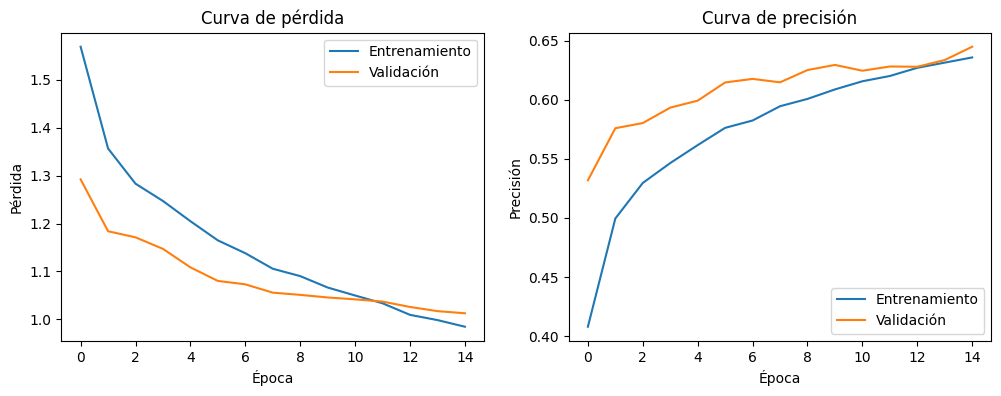

In [45]:
import matplotlib.pyplot as plt


train_loss = historymodelBertCnn.history['loss']
val_loss = historymodelBertCnn.history['val_loss']
train_accuracy = historymodelBertCnn.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertCnn.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [47]:
from keras import layers
from keras import Model

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

x_1 = layers.Conv1D(filters=32, kernel_size=(3), activation="relu", padding="same")(sequence_output)
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=32, kernel_size=(4), activation="relu", padding="same")(sequence_output)
x_2 = layers.GlobalMaxPooling1D()(x_2)

#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

merged = tf.concat([x_1, x_2], axis=-1)
dropout = layers.Dropout(0.5)(merged)
#last_dense = layers.Dense(units=256, activation="relu")(dropout)
#dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertCnn2 = Model(inputs=inputs_full, outputs=output)

modelBertCnn2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_9 (Lambda)              (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_10 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_11 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

In [48]:
historymodelBertCnn2 =  modelBertCnn2.fit(
    train_dataset,
    epochs=15,
    validation_data = val_dataset
    #callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/15
492/492 [==============================] - 707s 1s/step - loss: 1.4891 - sparse_categorical_accuracy: 0.4464 - val_loss: 1.2621 - val_sparse_categorical_accuracy: 0.5443
Epoch 2/15
492/492 [==============================] - 594s 1s/step - loss: 1.2729 - sparse_categorical_accuracy: 0.5377 - val_loss: 1.1410 - val_sparse_categorical_accuracy: 0.5894
Epoch 3/15
492/492 [==============================] - 595s 1s/step - loss: 1.1975 - sparse_categorical_accuracy: 0.5657 - val_loss: 1.1132 - val_sparse_categorical_accuracy: 0.6011
Epoch 4/15
492/492 [==============================] - 595s 1s/step - loss: 1.1409 - sparse_categorical_accuracy: 0.5859 - val_loss: 1.0663 - val_sparse_categorical_accuracy: 0.6132
Epoch 5/15
492/492 [==============================] - 595s 1s/step - loss: 1.0891 - sparse_categorical_accuracy: 0.6072 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.6234
Epoch 6/15
492/492 [==============================] - 596s 1s/step - loss: 1.0526 - sparse_cate

### Model Bert + NgramCNN + One Layer Attention

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa de atención
attention = Attention()([sequence_output, sequence_output])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(attention)
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(attention)
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(attention)
x_3 = layers.GlobalMaxPooling1D()(x_3)

merged = tf.concat([x_1, x_2, x_3], axis=-1)

last_dense = layers.Dense(units=256, activation="relu")(merged)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertCnn2 = Model(inputs=inputs_full, outputs=output)

modelBertCnn2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn2.summary()

### Model Bert + CNN + Attention layers

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa de atención
attention = Attention()([sequence_output, sequence_output])

x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(attention)
x_1 = Attention()([x_1, x_1])
x_1 = layers.GlobalMaxPooling1D()(x_1)
x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(attention)
x_2 = Attention()([x_2, x_2])
x_2 = layers.GlobalMaxPooling1D()(x_2)
x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(attention)
x_3 = Attention()([x_3, x_3])
x_3 = layers.GlobalMaxPooling1D()(x_3)

merged = tf.concat([x_1, x_2, x_3], axis=-1)

last_dense = layers.Dense(units=256, activation="relu")(merged)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertCnn3 = Model(inputs=inputs_full, outputs=output)

modelBertCnn3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertCnn3.summary()

### Model Bert + BiLSTM

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM.summary()

### Model Bert + BiLStm + Attention layer

In [ ]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Attention

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

attention1 = Attention()([sequence_output, sequence_output])

x = Bidirectional(LSTM(768, return_sequences=True))(attention1)
attention2 = Attention()([x, x])
x = layers.GlobalMaxPooling1D()(attention2)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTMAttention = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTMAttention.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTMAttention.summary()

### MODEL BERT + BiLSTM

In [196]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_27 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_28 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_29 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                            

### MODEL BERT + 2 BiLSTM

In [208]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(32, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

#last_dense = layers.Dense(units=32, activation="relu")(x)
dropout = layers.Dropout(0.5)(x)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertBiLSTM3Models2 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_48 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_49 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_50 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

In [209]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('model/BERT/BiLstm5/64batch', exist_ok=True)


checkpoint_path = 'model/BERT/BiLstm5/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/BiLstm5/64batch', exist_ok=True)



log_dir = "logs/BERT/BiLstm5/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [210]:
historymodelBertBiLSTM3Models2 =  modelBertBiLSTM3Models2.fit(
    train_dataset,
    epochs=10,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    492/Unknown - 609s 928ms/step - loss: 1.4540 - sparse_categorical_accuracy: 0.4539
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.54821, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_01_val_0.5482


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_01_val_0.5482\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_01_val_0.5482\assets


492/492 [==============================] - 926s 2s/step - loss: 1.4540 - sparse_categorical_accuracy: 0.4539 - val_loss: 1.2376 - val_sparse_categorical_accuracy: 0.5482
Epoch 2/10
492/492 [==============================] - ETA: 0s - loss: 1.2398 - sparse_categorical_accuracy: 0.5507
Epoch 2: val_sparse_categorical_accuracy improved from 0.54821 to 0.58717, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_02_val_0.5872


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_02_val_0.5872\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_02_val_0.5872\assets


492/492 [==============================] - 837s 2s/step - loss: 1.2398 - sparse_categorical_accuracy: 0.5507 - val_loss: 1.1323 - val_sparse_categorical_accuracy: 0.5872
Epoch 3/10
492/492 [==============================] - ETA: 0s - loss: 1.1523 - sparse_categorical_accuracy: 0.5829
Epoch 3: val_sparse_categorical_accuracy improved from 0.58717 to 0.60815, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_03_val_0.6081


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_03_val_0.6081\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_03_val_0.6081\assets


492/492 [==============================] - 770s 1s/step - loss: 1.1523 - sparse_categorical_accuracy: 0.5829 - val_loss: 1.0853 - val_sparse_categorical_accuracy: 0.6081
Epoch 4/10
492/492 [==============================] - ETA: 0s - loss: 1.1001 - sparse_categorical_accuracy: 0.6034
Epoch 4: val_sparse_categorical_accuracy improved from 0.60815 to 0.61138, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_04_val_0.6114


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_04_val_0.6114\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_04_val_0.6114\assets


492/492 [==============================] - 768s 2s/step - loss: 1.1001 - sparse_categorical_accuracy: 0.6034 - val_loss: 1.0740 - val_sparse_categorical_accuracy: 0.6114
Epoch 5/10
492/492 [==============================] - ETA: 0s - loss: 1.0482 - sparse_categorical_accuracy: 0.6230
Epoch 5: val_sparse_categorical_accuracy improved from 0.61138 to 0.62913, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_05_val_0.6291


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_05_val_0.6291\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_05_val_0.6291\assets


492/492 [==============================] - 785s 2s/step - loss: 1.0482 - sparse_categorical_accuracy: 0.6230 - val_loss: 1.0337 - val_sparse_categorical_accuracy: 0.6291
Epoch 6/10
492/492 [==============================] - ETA: 0s - loss: 1.0029 - sparse_categorical_accuracy: 0.6409
Epoch 6: val_sparse_categorical_accuracy improved from 0.62913 to 0.63772, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_06_val_0.6377


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_06_val_0.6377\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_06_val_0.6377\assets


492/492 [==============================] - 888s 2s/step - loss: 1.0029 - sparse_categorical_accuracy: 0.6409 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.6377
Epoch 7/10
492/492 [==============================] - ETA: 0s - loss: 0.9623 - sparse_categorical_accuracy: 0.6578
Epoch 7: val_sparse_categorical_accuracy improved from 0.63772 to 0.64475, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_07_val_0.6448


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_07_val_0.6448\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_07_val_0.6448\assets


492/492 [==============================] - 763s 1s/step - loss: 0.9623 - sparse_categorical_accuracy: 0.6578 - val_loss: 0.9929 - val_sparse_categorical_accuracy: 0.6448
Epoch 8/10
492/492 [==============================] - ETA: 0s - loss: 0.9247 - sparse_categorical_accuracy: 0.6713
Epoch 8: val_sparse_categorical_accuracy improved from 0.64475 to 0.65413, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_08_val_0.6541


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_08_val_0.6541\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_08_val_0.6541\assets


492/492 [==============================] - 768s 2s/step - loss: 0.9247 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.6541
Epoch 9/10
492/492 [==============================] - ETA: 0s - loss: 0.8813 - sparse_categorical_accuracy: 0.6883
Epoch 9: val_sparse_categorical_accuracy improved from 0.65413 to 0.66083, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_09_val_0.6608


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_09_val_0.6608\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_09_val_0.6608\assets


492/492 [==============================] - 824s 2s/step - loss: 0.8813 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.6608
Epoch 10/10
492/492 [==============================] - ETA: 0s - loss: 0.8477 - sparse_categorical_accuracy: 0.7000
Epoch 10: val_sparse_categorical_accuracy improved from 0.66083 to 0.66775, saving model to model/BERT/BiLstm5/64batch\BERT_CNN_model_best_10_val_0.6677


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_10_val_0.6677\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_10_val_0.6677\assets


492/492 [==============================] - 765s 1s/step - loss: 0.8477 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.6677


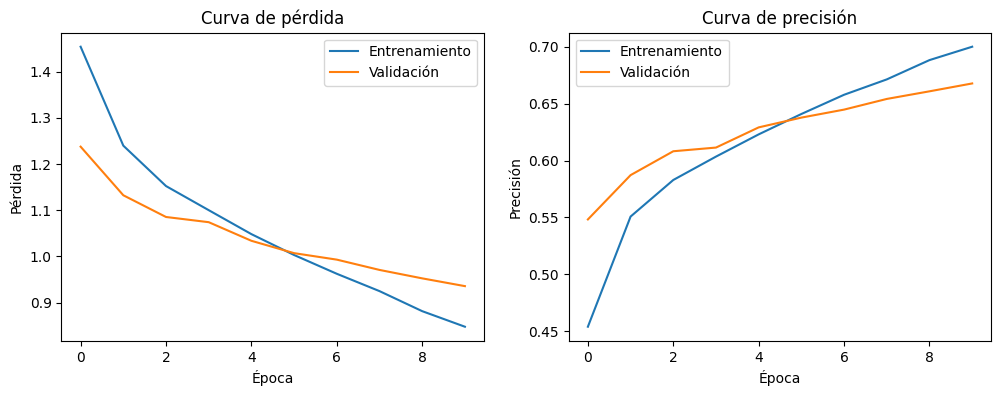

In [211]:
import matplotlib.pyplot as plt


train_loss = historymodelBertBiLSTM3Models2.history['loss']
val_loss = historymodelBertBiLSTM3Models2.history['val_loss']
train_accuracy = historymodelBertBiLSTM3Models2.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertBiLSTM3Models2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [212]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(32, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=32, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(dropout)

modelBertBiLSTM3Models2 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_51 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_52 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_53 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

In [213]:
historymodelBertBiLSTM3Models2 =  modelBertBiLSTM3Models2.fit(
    train_dataset,
    epochs=10,
    validation_data = val_dataset,
    callbacks = [model_checkpoint,tensorboard_callback]
)

Epoch 1/10
    492/Unknown - 616s 926ms/step - loss: 1.5671 - sparse_categorical_accuracy: 0.4010
Epoch 1: val_sparse_categorical_accuracy did not improve from 0.66775
492/492 [==============================] - 792s 1s/step - loss: 1.5671 - sparse_categorical_accuracy: 0.4010 - val_loss: 1.2993 - val_sparse_categorical_accuracy: 0.5354
Epoch 2/10
492/492 [==============================] - ETA: 0s - loss: 1.3299 - sparse_categorical_accuracy: 0.5218
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.66775
492/492 [==============================] - 632s 1s/step - loss: 1.3299 - sparse_categorical_accuracy: 0.5218 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.5833
Epoch 3/10
492/492 [==============================] - ETA: 0s - loss: 1.2272 - sparse_categorical_accuracy: 0.5657
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.66775
492/492 [==============================] - 631s 1s/step - loss: 1.2272 - sparse_categorical_accuracy: 0.5657 - val_loss: 1

INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_08_val_0.6765\assets


INFO:tensorflow:Assets written to: model/BERT/BiLstm5/64batch\BERT_CNN_model_best_08_val_0.6765\assets


492/492 [==============================] - 807s 2s/step - loss: 0.8610 - sparse_categorical_accuracy: 0.7054 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.6765
Epoch 9/10
122/492 [======>.......................] - ETA: 5:51 - loss: 0.8001 - sparse_categorical_accuracy: 0.7355

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


train_loss = historymodelBertBiLSTM3Models2.history['loss']
val_loss = historymodelBertBiLSTM3Models2.history['val_loss']
train_accuracy = historymodelBertBiLSTM3Models2.history['sparse_categorical_accuracy']
val_accuracy = historymodelBertBiLSTM3Models2.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### MODEL BERT + 2 BiLSTM - 2

In [286]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(sequence_output)
x = Attention(use_scale=True)([x, x])
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=128, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models3 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models3.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_36 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_37 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_38 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

### Paper Dual Channel

In [296]:
from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Conv1D, Dropout
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])


Layer1 = Bidirectional(LSTM(32, return_sequences=True))(sequence_output)
Layer1 = Conv1D(filters=32, kernel_size=400)(Layer1)
Layer1 = Dropout(0.3)(Layer1)
#Layer1 = Dropout(0.5)(Layer1)

Layer2 = Conv1D(filters=32, kernel_size=400)(sequence_output)
Layer2 = Dropout(0.3)(Layer2)
#Layer2 = Dropout(0.5)(Layer2)
Layer2 = Bidirectional(LSTM(32, return_sequences=True))(Layer2)

x= tf.concat([Layer1,Layer2], axis=-1)
x = layers.MaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
last_dense = layers.Dense(units=512, activation="relu")(x)
#last_dropout = layers.Dropout(0.5)(x)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertDualChannel = Model(inputs=inputs_full, outputs=output)

modelBertDualChannel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [297]:
modelBertDualChannel.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 3, 300)]     0           []                               
                                                                                                  
 lambda_48 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_49 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                                  
 lambda_50 (Lambda)             (None, 300)          0           ['inputs[0][0]']                 
                                                                                           

In [298]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('BERT/Model2/modelBertDualChannel/64batch', exist_ok=True)


checkpoint_path = 'BERT/Model2/modelBertDualChannel/64batch/BERT_CNN_model_best_{epoch:02d}_val_{val_sparse_categorical_accuracy:.4f}'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
    save_format='tf',
    save_weights_only=False,
)


#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/BERT/Model2/modelBertDualChannel/64batch', exist_ok=True)



log_dir = "logs/BERT/Model2/modelBertDualChannel/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Alternatives

In [184]:
#from keras import layers
#from keras import Model
#from keras import regularizers

#inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
#input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
#input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
#input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

#bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

#pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

#x_1 = layers.Conv1D(filters=50, kernel_size=2, activation="relu", padding="same")(sequence_output)
#x_1 = layers.GlobalMaxPooling1D()(x_1)
#x_2 = layers.Conv1D(filters=50, kernel_size=3, activation="relu", padding="same")(sequence_output)
#x_2 = layers.GlobalMaxPooling1D()(x_2)
#x_3 = layers.Conv1D(filters=50, kernel_size=4, activation="relu", padding="same")(sequence_output)
#x_3 = layers.GlobalMaxPooling1D()(x_3)
#x_4 = layers.Conv1D(filters=50, kernel_size=5, activation="relu", padding="same")(sequence_output)
#x_4 = layers.GlobalMaxPooling1D()(x_4)

#merged = tf.concat([x_1, x_2, x_3, x_4], axis=-1)
#merged = tf.concat([x_1, x_2, x_3], axis=-1)
#dropout = layers.Dropout(0.5)(merged)
#last_dense = layers.Dense(units=256, activation="relu",kernel_regularizer=regularizers.L2(0.01))(dropout)
#dropout = layers.Dropout(0.5)(last_dense)
#output = layers.Dense(units=7, activation="softmax")(dropout)

#modelBertCnn = Model(inputs=inputs_full, outputs=output)

#modelBertCnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

#modelBertCnn.summary()

In [185]:
"""from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import initializers, regularizers, constraints



inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])


x = Bidirectional(LSTM(768, return_sequences=True, dropout=0.2))(sequence_output)
x = Attention(use_scale=True)([x, x])
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
x = Attention(use_scale=True)([x, x])
#x = Attention(use_scale=True)([x, x])
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=128, activation="relu")(x)
dropout = layers.Dropout(0.5)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models4 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models4.summary()"""

'from keras import layers\nfrom keras import Model\nfrom tensorflow.keras.layers import Bidirectional, LSTM\n#from keras_self_attention import SeqSelfAttention\nfrom tensorflow.keras.layers import Attention\nfrom keras import backend as K\nfrom keras import initializers, regularizers, constraints\n\n\n\ninputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name=\'inputs\')\ninput_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\n\nbert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)\n\npooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])\n\n# Aplicar capa bidireccional\nx = Bidirectional(LSTM(768, return_sequences=True, dropout=0.2))(sequence_ou

In [186]:
"""from keras import layers
from keras import Model
from tensorflow.keras.layers import Bidirectional, LSTM

inputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name='inputs')
input_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)
input_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)

pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])

# Aplicar capa bidireccional
x = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)
x = layers.GlobalMaxPooling1D()(x)

last_dense = layers.Dense(units=256, activation="relu")(x)
dropout = layers.Dropout(0.4)(last_dense)
output = layers.Dense(units=7, activation="softmax")(last_dense)

modelBertBiLSTM3Models6 = Model(inputs=inputs_full, outputs=output)

modelBertBiLSTM3Models6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

modelBertBiLSTM3Models6.summary()"""

'from keras import layers\nfrom keras import Model\nfrom tensorflow.keras.layers import Bidirectional, LSTM\n\ninputs_full = layers.Input(shape=(3,SEQUENCE_LENGTH,), dtype=tf.int32, name=\'inputs\')\ninput_word_ids = layers.Lambda(lambda x: x[:, 0 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_mask = layers.Lambda(lambda x: x[:, 1 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\ninput_type_ids = layers.Lambda(lambda x: x[:, 2 ,:], output_shape=(SEQUENCE_LENGTH,))(inputs_full)\n\nbert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1",trainable=False)\n\npooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_ids])\n\n# Aplicar capa bidireccional\nx = Bidirectional(LSTM(768, return_sequences=True))(sequence_output)\nx = layers.GlobalMaxPooling1D()(x)\n\nlast_dense = layers.Dense(units=256, activation="relu")(x)\ndropout = layers.Dropout(0.4)(last_dense)\noutput = layers.Dense(units=7, activation="softmax")(last_d

## Modelos Con Embeddings entrenados

### Tokenización

In [238]:
tokenizerNormal = Tokenizer()
tokenizerNormal.fit_on_texts(texto_clean)
sequences = tokenizerNormal.texts_to_sequences(texto_clean)
sequences

[[328, 1, 2, 3, 330, 135, 19, 7, 10703, 10704, 51, 3, 10705, 5, 10706, 1187],
 [8, 3290, 13, 81, 349, 439],
 [11, 1, 14, 11, 1, 14],
 [32, 472, 140, 4, 159, 557, 49, 81, 1324],
 [126, 670, 2, 409, 4, 327, 1796, 32, 670, 13, 4, 218, 9, 1324],
 [1, 62],
 [42, 6069, 2, 1436, 106, 536, 8, 32, 8, 90, 1619, 4, 352, 979, 19, 103],
 [89, 5, 30],
 [27, 90, 23, 123, 2688],
 [40,
  78,
  99,
  526,
  13,
  4,
  8446,
  491,
  17,
  8,
  19,
  2466,
  42,
  1,
  53,
  1,
  90,
  85,
  18,
  69,
  1410,
  670,
  1013,
  10,
  59,
  100],
 [1006, 8, 90, 1687],
 [348],
 [40, 78, 59],
 [73, 280],
 [94, 1970],
 [94, 94, 94, 8, 365, 93, 146, 102, 11, 1205],
 [73, 2181, 438, 221, 16, 123, 69, 625, 873, 177],
 [90, 1, 22, 4, 1188],
 [94, 14, 8, 353, 4, 665],
 [2, 16, 3, 1971, 122],
 [31, 2, 18, 39, 12, 31, 444, 25, 3291],
 [10707, 7065, 32, 1265, 18, 341, 1380],
 [126, 11, 298, 886, 8, 8, 329, 1265, 202, 1024],
 [14],
 [395, 215, 25, 1079, 2, 19, 7, 725, 757, 32, 1],
 [36],
 [355],
 [355],
 [3472, 14, 16,

In [172]:
df_resampled

,texto,label
0,also I was the point person on my company's tr...,neutral
1,You must've had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let's talk a little bit about your duties.,neutral
4,"Now you'll be heading a whole division, so you...",neutral
...,...,...
44914,"[When my friend, as common, forget the tickets...",angry
44915,[When I was erroneously accused of being a thi...,angry
44916,[I want something to change by reversal come o...,angry
44917,[A father helping his youngster to contend oth...,angry


In [173]:
data_labels[-1]

0

In [102]:
texto_clean[0:10]

["also i be the point person on my company's transition from the kl to gr system.",
 "you must've have your hand full.",
 'that i do. that i do.',
 "so let's talk a little bit about your duty.",
 "now you'll be head a whole division so you'll have a lot of duty.",
 'i see.',
 "but there'll be perhaps people under you so you can dump a certain amount on them.",
 'good to know.',
 'we can go into detail',
 "all right then we'll have a definite answer for you on monday but i think i can say with some confidence you'll fit in well here."]

In [103]:
sequences[0:10]

[[328, 1, 2, 3, 330, 135, 19, 7, 10703, 10704, 51, 3, 10705, 5, 10706, 1187],
 [8, 3290, 13, 81, 349, 439],
 [11, 1, 14, 11, 1, 14],
 [32, 472, 140, 4, 159, 557, 49, 81, 1324],
 [126, 670, 2, 409, 4, 327, 1796, 32, 670, 13, 4, 218, 9, 1324],
 [1, 62],
 [42, 6069, 2, 1436, 106, 536, 8, 32, 8, 90, 1619, 4, 352, 979, 19, 103],
 [89, 5, 30],
 [27, 90, 23, 123, 2688],
 [40,
  78,
  99,
  526,
  13,
  4,
  8446,
  491,
  17,
  8,
  19,
  2466,
  42,
  1,
  53,
  1,
  90,
  85,
  18,
  69,
  1410,
  670,
  1013,
  10,
  59,
  100]]

In [239]:
import random

#Se crea una lista mediante la secuencia, su respectivo label y el largo de la frase.
data_with_len_normal = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(sequences)]


random.shuffle(data_with_len_normal)

#Ordena los datos segun el largo de la secuencia obtenida mediante el len(sent) de la segunda posición
#data_with_len.sort(key=lambda x: x[2])

valor_maximo=-np.inf

for sent_lab in data_with_len_normal:
    if sent_lab[2]>valor_maximo:
        valor_maximo=sent_lab[2]

# Función generadora para el dataset
def generator():
    for sent, label, _ in data_with_len_normal:
        yield tf.constant(sent, dtype=tf.int32), tf.constant(label, dtype=tf.int32)



all_dataset_normal = tf.data.Dataset.from_generator(generator,
                                             output_types=(tf.int32, tf.int32))

# Batch y padding del dataset
BATCH_SIZE_NORMAL = 32
all_batched_normal = all_dataset_normal.padded_batch(BATCH_SIZE_NORMAL,
                                       padded_shapes=([300], []),
                                       padding_values=(0, 0))

In [177]:
data_with_len_normal[0:10]

[[[24, 81, 5847], 5, 3],
 [[29, 12542], 5, 2],
 [[303], 6, 1],
 [[87, 14, 8, 1399], 2, 4],
 [[1, 14, 21, 30, 476], 4, 5],
 [[14, 8, 140, 5, 56], 5, 5],
 [[784, 57, 151], 5, 3],
 [[94], 4, 1],
 [[13917, 2813, 4, 1066, 10, 4, 8156, 375, 18, 4, 2846], 1, 11],
 [[76,
   72,
   2,
   865,
   5578,
   6,
   3202,
   75,
   84,
   456,
   40,
   9,
   4,
   929,
   50,
   1,
   2,
   23,
   144,
   3,
   2707,
   1,
   2,
   400,
   47,
   161,
   1,
   63,
   21,
   256,
   33,
   19,
   3202,
   150,
   3,
   2707,
   6,
   13,
   5,
   2,
   306,
   4378,
   2524,
   17,
   1092,
   16],
  2,
  46]]

In [178]:
for i, element in enumerate(all_batched_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   24,    81,  5847, ...,     0,     0,     0],
       [   29, 12542,     0, ...,     0,     0,     0],
       [  303,     0,     0, ...,     0,     0,     0],
       ...,
       [   79,     4,  1467, ...,     0,     0,     0],
       [  162,   978,    19, ...,     0,     0,     0],
       [  476,  1654,  1947, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 5, 6, 2, 4, 5, 5, 4, 1, 2, 6, 2, 1, 1, 3, 4, 6, 0, 5, 5, 5, 0,
       3, 3, 2, 2, 6, 2, 3, 0, 1, 0])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   1,  112,    4, ...,    0,    0,    0],
       [   1,    2,   41, ...,    0,    0,    0],
       [  88, 2532,    0, ...,    0,    0,    0],
       ...,
       [ 120,    2,  158, ...,    0,    0,    0],
       [ 424,  310,   65, ...,    0,    0,    0],
       [ 291,  284,  284, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([

In [185]:
first = next(iter(all_batched_normal.take(1)))

print(first[0][24])

tf.Tensor(
[  70    1   13  847    5  283    7  117   97   20  234  137    2  473
   50    5   26    1    2   23    5   14   18    7  878  137   14   21
  560    4 6405  317    6  414    1   14   21   46  133   82   63  369
    7  121  236   44 7419   97   20  234    5 1939  150    6 3246   10
    7  244    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [171]:
data_with_len_normal[60:100]

[[[312, 8], 4, 2],
 [[94], 4, 1],
 [[341], 4, 1],
 [[42, 275, 1, 14, 21, 53, 60, 261, 531], 4, 9],
 [[125, 88, 44, 7067, 3292, 2825, 10718, 51, 5346], 4, 9],
 [[32, 148, 186], 4, 3],
 [[59, 59, 5, 2364, 38, 247, 13, 551, 8, 83, 241], 4, 11],
 [[84], 4, 1],
 [[42, 88, 24, 479, 32, 32, 1797, 4, 1469, 5, 7, 980], 4, 12],
 [[77], 4, 1],
 [[8, 14, 21, 53, 25, 2, 184, 801], 4, 8],
 [[211, 90, 1, 140, 5, 8, 17, 4, 464], 4, 9],
 [[197, 322, 32, 315, 23, 19], 4, 6],
 [[94, 8, 348], 4, 3],
 [[66, 2, 8449, 66, 2, 171, 404, 11, 1, 53, 16, 2, 55, 5, 271, 16, 18, 233],
  4,
  18],
 [[1, 185, 5, 346, 11, 1, 2, 13, 282, 17, 162, 269], 4, 12],
 [[348, 1620, 179, 80, 9, 3, 4803, 8, 30, 26, 164, 5, 3, 10719, 4359], 4, 15],
 [[36, 1860, 3715, 247, 325, 9, 10, 3, 589, 9, 4, 770, 100], 4, 13],
 [[73, 90, 8, 122, 35, 356, 56, 10, 3, 2967, 338], 4, 11],
 [[1, 91, 247, 3293, 78], 4, 5],
 [[36, 73, 1688, 85, 66, 468, 2, 5347, 1300], 4, 9],
 [[73, 656, 11, 132, 31, 13, 4, 77, 243, 627], 4, 10],
 [[82, 8, 85, 243

In [127]:
len(data_with_len_normal)

44919

In [240]:
import math

# Calcular el número total de lotes
NB_BATCHES = math.ceil(len(data_with_len_normal) / BATCH_SIZE)
print("NB_BATCHES totales: ",NB_BATCHES)

# Calcular el número de lotes para validación y prueba
NB_BATCHES_VAL = (NB_BATCHES * 20) // 100
NB_BATCHES_TEST = (NB_BATCHES * 10) // 100
print("NB_BATCHES validacion: ",NB_BATCHES_VAL)
print("NB_BATCHES testeo: ",NB_BATCHES_TEST)
print("NB_BATCHES entrenamiento", NB_BATCHES - (NB_BATCHES_TEST + NB_BATCHES_VAL))

# Se crea los conjuntos de datos para entrenamiento, validación y prueba
val_dataset_normal = all_batched_normal.take(NB_BATCHES_VAL)
test_dataset_normal = all_batched_normal.skip(NB_BATCHES_VAL).take(NB_BATCHES_TEST)
train_dataset_normal = all_batched_normal.skip(NB_BATCHES_VAL + NB_BATCHES_TEST) 

BUFFER_SIZE = 10000  
train_dataset_normal = train_dataset_normal.shuffle(BUFFER_SIZE)



NB_BATCHES totales:  1404
NB_BATCHES validacion:  280
NB_BATCHES testeo:  140
NB_BATCHES entrenamiento 984


In [241]:
print(len(list(val_dataset_normal)))
print(len(list(test_dataset_normal)))
print(len(list(train_dataset_normal)))

280
140
984


In [191]:
for i, element in enumerate(val_dataset_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)

Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   24,    81,  5847, ...,     0,     0,     0],
       [   29, 12542,     0, ...,     0,     0,     0],
       [  303,     0,     0, ...,     0,     0,     0],
       ...,
       [   79,     4,  1467, ...,     0,     0,     0],
       [  162,   978,    19, ...,     0,     0,     0],
       [  476,  1654,  1947, ...,     0,     0,     0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 5, 6, 2, 4, 5, 5, 4, 1, 2, 6, 2, 1, 1, 3, 4, 6, 0, 5, 5, 5, 0,
       3, 3, 2, 2, 6, 2, 3, 0, 1, 0])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[   1,  112,    4, ...,    0,    0,    0],
       [   1,    2,   41, ...,    0,    0,    0],
       [  88, 2532,    0, ...,    0,    0,    0],
       ...,
       [ 120,    2,  158, ...,    0,    0,    0],
       [ 424,  310,   65, ...,    0,    0,    0],
       [ 291,  284,  284, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([

In [190]:
for i, element in enumerate(train_dataset_normal.take(30)):
    print(f"Elemento {i+1}:")
    print(element)


Elemento 1:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[  70,   13,    2, ...,    0,    0,    0],
       [   8,  192,   21, ...,    0,    0,    0],
       [  12,    1,  283, ...,    0,    0,    0],
       ...,
       [   1,   91,    8, ...,    0,    0,    0],
       [   2,   98,   20, ...,    0,    0,    0],
       [  12,    1, 1250, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([5, 0, 5, 6, 2, 2, 6, 0, 6, 6, 4, 4, 6, 4, 5, 2, 0, 4, 2, 0, 3, 0,
       1, 5, 1, 4, 1, 6, 2, 5, 1, 1])>)
Elemento 2:
(<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[ 852, 3029,  150, ...,    0,    0,    0],
       [ 178,    3,  857, ...,    0,    0,    0],
       [  78,   32,    3, ...,    0,    0,    0],
       ...,
       [   6, 2625, 4245, ...,    0,    0,    0],
       [  12,    1,  283, ...,    0,    0,    0],
       [   4, 1656,    9, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 5, 4, 4, 6, 5, 6, 3, 5, 1, 0, 6, 

In [242]:
maximo_largo =300 #Maximo largo de la secuencia
vocab_size = len(tokenizerNormal.word_index) + 1
vocab_size

15114

In [243]:
vocab = tokenizerNormal.word_index
vocab

{'i': 1,
 'be': 2,
 'the': 3,
 'a': 4,
 'to': 5,
 'and': 6,
 'my': 7,
 'you': 8,
 'of': 9,
 'in': 10,
 'that': 11,
 'when': 12,
 'have': 13,
 'do': 14,
 'me': 15,
 'it': 16,
 'for': 17,
 'with': 18,
 'on': 19,
 'at': 20,
 "n't": 21,
 'get': 22,
 'go': 23,
 'not': 24,
 'this': 25,
 'what': 26,
 'we': 27,
 'one': 28,
 'no': 29,
 'know': 30,
 'he': 31,
 'so': 32,
 'out': 33,
 'friend': 34,
 'just': 35,
 'oh': 36,
 'she': 37,
 'up': 38,
 'her': 39,
 'all': 40,
 'very': 41,
 'but': 42,
 'come': 43,
 'an': 44,
 'like': 45,
 'make': 46,
 'by': 47,
 'information': 48,
 'about': 49,
 'as': 50,
 'from': 51,
 'they': 52,
 'think': 53,
 'would': 54,
 'time': 55,
 'him': 56,
 "i'm": 57,
 'state': 58,
 'well': 59,
 "it's": 60,
 'want': 61,
 'see': 62,
 'could': 63,
 'his': 64,
 'take': 65,
 'there': 66,
 'because': 67,
 'technology': 68,
 'some': 69,
 'after': 70,
 'tell': 71,
 'number': 72,
 'yeah': 73,
 'who': 74,
 'felt': 75,
 'atomic': 76,
 'really': 77,
 'right': 78,
 "you're": 79,
 'day': 80,


### Word2Vec concatenado con FastText

In [244]:
texto_clean_split = [text.split() for text in texto_clean]
texto_clean_split

[['also',
  'i',
  'be',
  'the',
  'point',
  'person',
  'on',
  'my',
  "company's",
  'transition',
  'from',
  'the',
  'kl',
  'to',
  'gr',
  'system.'],
 ['you', "must've", 'have', 'your', 'hand', 'full.'],
 ['that', 'i', 'do.', 'that', 'i', 'do.'],
 ['so', "let's", 'talk', 'a', 'little', 'bit', 'about', 'your', 'duty.'],
 ['now',
  "you'll",
  'be',
  'head',
  'a',
  'whole',
  'division',
  'so',
  "you'll",
  'have',
  'a',
  'lot',
  'of',
  'duty.'],
 ['i', 'see.'],
 ['but',
  "there'll",
  'be',
  'perhaps',
  'people',
  'under',
  'you',
  'so',
  'you',
  'can',
  'dump',
  'a',
  'certain',
  'amount',
  'on',
  'them.'],
 ['good', 'to', 'know.'],
 ['we', 'can', 'go', 'into', 'detail'],
 ['all',
  'right',
  'then',
  "we'll",
  'have',
  'a',
  'definite',
  'answer',
  'for',
  'you',
  'on',
  'monday',
  'but',
  'i',
  'think',
  'i',
  'can',
  'say',
  'with',
  'some',
  'confidence',
  "you'll",
  'fit',
  'in',
  'well',
  'here.'],
 ['absolutely.', 'you', 

In [245]:
import gensim

In [246]:
DIM = 300 #maximo largo de la secuencia
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado Word2vec
fasttext_model = gensim.models.FastText(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado FastText
#Tiene que aparecer una vez como minimo en la secuencia para considerarlo

w2v_model

In [ ]:
w2v_model.wv['meaning']

In [247]:
import numpy as np

def get_weights_matrix_embedding_word2vec(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #En caso de que no exista en el vocabulario de Word2Vec ocupa FastText


    return weights_matrix

In [248]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
Embeddings_Word2Vec_FastText = get_weights_matrix_embedding_word2vec(w2v_model, fasttext_model)

In [249]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[Embeddings_Word2Vec_FastText], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout = Dropout(0.5)(lstm1)
lstm2 = Bidirectional(LSTM(128))(dropout)
dense = Dense(32)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2Vec = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2Vec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2Vec.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 300, 300)          4534200   
                                                                 
 bidirectional_26 (Bidirecti  (None, 300, 256)         439296    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 300, 256)          0         
                                                                 
 bidirectional_27 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_30 (Dense)            (None, 32)                822

In [250]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('Embeddings/Word2Vec_FastText/BiLstm/64batch', exist_ok=True)


checkpoint_path = 'Embeddings/Word2Vec_FastText/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/Embeddings/Word2Vec_FastText/BiLstm/64batch', exist_ok=True)



log_dir = "logs/Embeddings/Word2Vec_FastText/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [251]:
historyWord2Vec = modelBiLstmWord2Vec.fit(
    train_dataset_normal,
    validation_data=val_dataset_normal,
    epochs=15,
    callbacks=[model_checkpoint, tensorboard_callback]
) 

Epoch 1/15
    984/Unknown - 327s 173ms/step - loss: 1.6092 - sparse_categorical_accuracy: 0.3625
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.40714, saving model to Embeddings/Word2Vec_FastText/BiLstm/64batch\best_model_modelLSTM_1_0.4071.h5
984/984 [==============================] - 384s 231ms/step - loss: 1.6092 - sparse_categorical_accuracy: 0.3625 - val_loss: 1.5070 - val_sparse_categorical_accuracy: 0.4071
Epoch 2/15
984/984 [==============================] - ETA: 0s - loss: 1.4643 - sparse_categorical_accuracy: 0.4375
Epoch 2: val_sparse_categorical_accuracy improved from 0.40714 to 0.45882, saving model to Embeddings/Word2Vec_FastText/BiLstm/64batch\best_model_modelLSTM_2_0.4588.h5
984/984 [==============================] - 286s 211ms/step - loss: 1.4643 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.4129 - val_sparse_categorical_accuracy: 0.4588
Epoch 3/15
984/984 [==============================] - ETA: 0s - loss: 1.3559 - sparse_categorical_accuracy: 

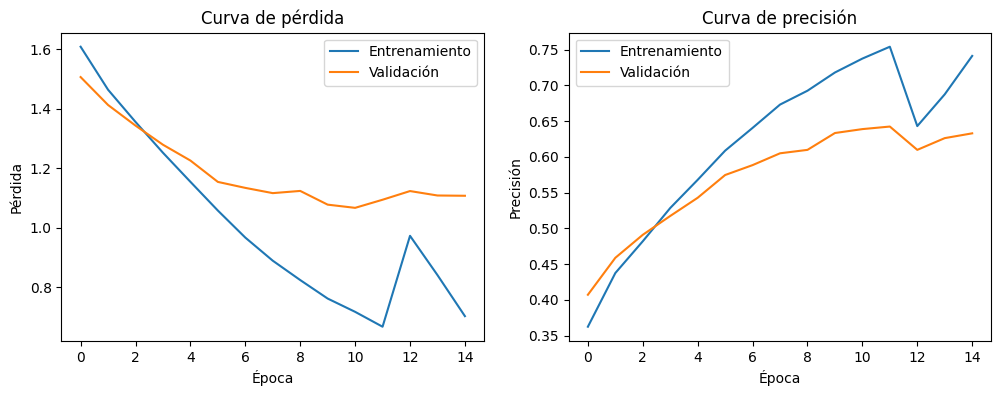

In [252]:
import matplotlib.pyplot as plt


train_loss = historyWord2Vec.history['loss']
val_loss = historyWord2Vec.history['val_loss']
train_accuracy = historyWord2Vec.history['sparse_categorical_accuracy']
val_accuracy = historyWord2Vec.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Word2Vec + FastText separados

In [253]:
DIM = 300 #maximo largo de la secuencia
maxlen=300
w2v_model = gensim.models.Word2Vec(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado Word2vec
fasttext_model = gensim.models.FastText(sentences=texto_clean_split, vector_size=DIM, window=5, min_count=1) #Modelo pre-entrenado FastText
#Tiene que aparecer una vez como minimo en la secuencia para considerarlo

w2v_model

In [254]:
import numpy as np

def get_weights_matrix_embedding_word2vecFastText(model_w2v, fasttext_model):

    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo
    for word, index in vocab.items():
      try:
        weights_matrix[index] = model_w2v.wv[word] #obtiene los pesos de la palabra del modelo word2vec
      except KeyError:
        weights_matrix[index] = fasttext_model.wv[word] #en caso de no estar en el vocabulario de word2Vec ocupa FastText


    return weights_matrix


def get_weights_matrix_embedding(model):
    weights_matrix = np.zeros((vocab_size, DIM)) #el dim es la dimensión del modelo

    for word, index in vocab.items():
        weights_matrix[index] = model.wv[word] #obtiene los pesos de la palabra del modelo wor2vec

    return weights_matrix

In [255]:
#Creación del embedding, donde ingresa cada palabra al modelo y retorna los pesos
EmbeddingsW2Vec = get_weights_matrix_embedding_word2vecFastText(w2v_model, fasttext_model) #Pesos para Word2Vec con complemento de FastText
EmbeddingsFastText = get_weights_matrix_embedding(fasttext_model) #Pesos para FastText

In [256]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, concatenate, Dropout
from keras.models import Sequential, Model


maximo_largo_secuencias=300

input_seq  = Input(shape=(maximo_largo_secuencias,), dtype='int32')
embedding_word2vec = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsW2Vec], input_length=maximo_largo_secuencias, trainable=False)(input_seq)
embedding_fasttext = Embedding(input_dim=vocab_size, output_dim=maximo_largo_secuencias, weights=[EmbeddingsFastText], input_length=maximo_largo_secuencias, trainable=False)(input_seq)

lstm_word2vec = Bidirectional(LSTM(128))(embedding_word2vec)
dropout_word2vec = Dropout(0.5)(lstm_word2vec)

lstm_fasttext = Bidirectional(LSTM(128))(embedding_fasttext)
dropout_fastText = Dropout(0.5)(lstm_fasttext)


concatenated = concatenate([dropout_word2vec, dropout_fastText])

dense = Dense(32)(concatenated)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmWord2VecFastText = Model(inputs=input_seq, outputs=output)

modelBiLstmWord2VecFastText.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmWord2VecFastText.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 300, 300)     4534200     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 300, 300)     4534200     ['input_6[0][0]']                
                                                                                                  
 bidirectional_28 (Bidirectiona  (None, 256)         439296      ['embedding_5[0][0]']            
 l)                                                                                        

In [257]:
#--------------------Checkpoint--------------------

import os
from keras.callbacks import ModelCheckpoint,TensorBoard
from datetime import datetime

os.makedirs('Embeddings/Word2VecSeparadoFastText/BiLstm/64batch', exist_ok=True)


checkpoint_path = 'Embeddings/Word2VecSeparadoFastText/BiLstm/64batch/best_model_modelLSTM_{epoch}_{val_sparse_categorical_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/Embeddings/Word2VecSeparadoFastText/BiLstm/64batch', exist_ok=True)



log_dir = "logs/Embeddings/Word2VecSeparadoFastText/BiLstm/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [258]:
historyWord2VecFastText = modelBiLstmWord2VecFastText.fit(
    train_dataset_normal,
    validation_data=val_dataset_normal,
    epochs=15,
    callbacks=[model_checkpoint, tensorboard_callback]
)

Epoch 1/15
    984/Unknown - 346s 187ms/step - loss: 1.6241 - sparse_categorical_accuracy: 0.3571
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.40156, saving model to Embeddings/Word2VecSeparadoFastText/BiLstm/64batch\best_model_modelLSTM_1_0.4016.h5
984/984 [==============================] - 399s 241ms/step - loss: 1.6241 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.5286 - val_sparse_categorical_accuracy: 0.4016
Epoch 2/15
984/984 [==============================] - ETA: 0s - loss: 1.5136 - sparse_categorical_accuracy: 0.4129
Epoch 2: val_sparse_categorical_accuracy improved from 0.40156 to 0.43705, saving model to Embeddings/Word2VecSeparadoFastText/BiLstm/64batch\best_model_modelLSTM_2_0.4371.h5
984/984 [==============================] - 294s 218ms/step - loss: 1.5136 - sparse_categorical_accuracy: 0.4129 - val_loss: 1.4518 - val_sparse_categorical_accuracy: 0.4371
Epoch 3/15
984/984 [==============================] - ETA: 0s - loss: 1.4398 - sparse_categori

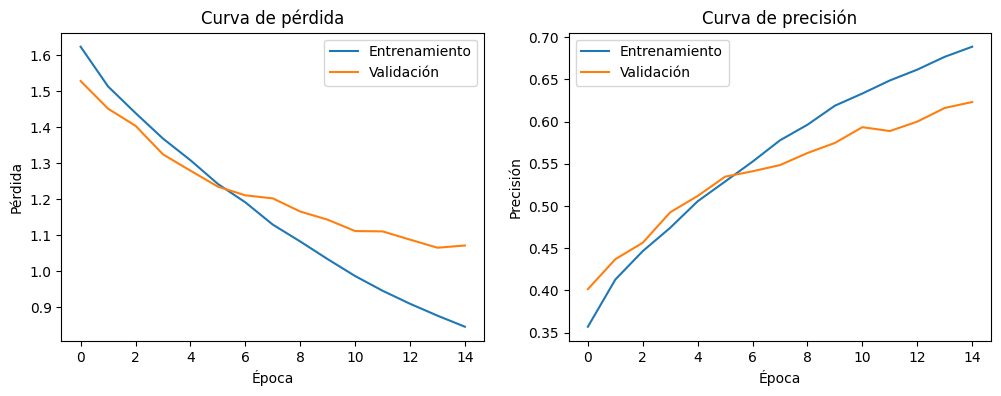

In [259]:
import matplotlib.pyplot as plt


train_loss = historyWord2VecFastText.history['loss']
val_loss = historyWord2VecFastText.history['val_loss']
train_accuracy = historyWord2VecFastText.history['sparse_categorical_accuracy']
val_accuracy = historyWord2VecFastText.history['val_sparse_categorical_accuracy']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Entrenamiento')
plt.plot(val_accuracy, label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### Glove

In [194]:
embedding_dictionary = dict()

glove_file = open('glove.6B.300d.txt', encoding='utf-8')
for linea in glove_file:
    values = linea.split()
    word = values[0]
    vector_dimensiones = np.asarray(values[1:], dtype="float32") #se obtiene el vector de pesos
    embedding_dictionary[word] = vector_dimensiones #a cada palabra se define el vector de pesos
glove_file.close()

In [196]:
def obtener_pesos_matrix_para_cada_palabra(call_model):
    weights_matrix = np.zeros((vocab_size, maximo_largo))

    for word, index in tokenizer.word_index.items():
        embedding_vector = call_model.get(word) #se transforma y se obtiene la matriz de pesos

        if embedding_vector is not None:
            weights_matrix[index] = embedding_vector
    return weights_matrix

In [213]:
Embeddings_Glove = obtener_pesos_matrix_para_cada_palabra(embedding_dictionary)

In [218]:
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model



input_seq  = Input(shape=(maximo_largo,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=maximo_largo, weights=[Embeddings_Glove], input_length=maximo_largo, trainable=False)(input_seq)
lstm1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(embedding_layer)
lstm2 = Bidirectional(LSTM(128, dropout=0.25))(lstm1)
dense = Dense(128)(lstm2)
dense = LeakyReLU(alpha=0.2)(dense)
output = Dense(7, activation="softmax")(dense)

modelBiLstmGlove = Model(inputs=input_seq, outputs=output)

modelBiLstmGlove.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

modelBiLstmGlove.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 300)          4534200   
                                                                 
 bidirectional_23 (Bidirecti  (None, 300, 512)         1140736   
 onal)                                                           
                                                                 
 bidirectional_24 (Bidirecti  (None, 256)              656384    
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0  